# Churn Prediction experimentation

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
# Read a CSV file into a DataFrame
df = pd.read_csv('churn_data_cleaned.csv')
df.head()

,CustomerID,Geography,Gender,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Inactive,Is_45_65,More_than_3_prods,older_with_loan,older_with_no_credit_card
0,5188208,Rest_GR,Male,18-25,0,40683.96,50086.2120,1,0,0,0.38,0,0,0,0,0
1,8683784,Thessaloniki,Female,65+,4,2429.51,0.0000,1,1,0,0.33,1,0,0,0,0
2,3512360,Athens,Male,45-55,4,41694.49,26852.7072,1,1,1,0.72,0,1,0,1,0
3,7104818,Rest_GR,Male,25-35,5,74523.33,90325.6200,1,0,0,0.08,0,0,0,0,0
4,6712745,Rest_GR,Female,25-35,9,111050.49,100537.0608,2,0,0,1.38,0,0,0,0,0


In [3]:
df.drop(['CustomerID'], axis=1, inplace=True)
df.head()

,Geography,Gender,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Inactive,Is_45_65,More_than_3_prods,older_with_loan,older_with_no_credit_card
0,Rest_GR,Male,18-25,0,40683.96,50086.2120,1,0,0,0.38,0,0,0,0,0
1,Thessaloniki,Female,65+,4,2429.51,0.0000,1,1,0,0.33,1,0,0,0,0
2,Athens,Male,45-55,4,41694.49,26852.7072,1,1,1,0.72,0,1,0,1,0
3,Rest_GR,Male,25-35,5,74523.33,90325.6200,1,0,0,0.08,0,0,0,0,0
4,Rest_GR,Female,25-35,9,111050.49,100537.0608,2,0,0,1.38,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Geography                  10000 non-null  object 
 1   Gender                     10000 non-null  object 
 2   Age_Band                   10000 non-null  object 
 3   TenureYears                10000 non-null  int64  
 4   EstimatedIncome            10000 non-null  float64
 5   BalanceEuros               10000 non-null  float64
 6   NoProducts                 10000 non-null  int64  
 7   CreditCardholder           10000 non-null  int64  
 8   CustomerWithLoan           10000 non-null  int64  
 9   Digital_TRX_ratio          10000 non-null  float64
 10  Inactive                   10000 non-null  int64  
 11  Is_45_65                   10000 non-null  int64  
 12  More_than_3_prods          10000 non-null  int64  
 13  older_with_loan            10000 non-null  int6

In [5]:
df.columns

Index(['Geography', 'Gender', 'Age_Band', 'TenureYears', 'EstimatedIncome',
       'BalanceEuros', 'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card'],
      dtype='object')

In [6]:
continuous_features = ['EstimatedIncome', 'BalanceEuros', 'Digital_TRX_ratio']
categorical_features = ['Geography', 'Gender', 'Age_Band', 'TenureYears', 'NoProducts', 'CreditCardholder', 'CustomerWithLoan',]
target = ['Inactive']

### Data Preprocessing

In [7]:
# numerical data to float64
df[continuous_features] = df[continuous_features].astype('float32')
df[continuous_features].dtypes

EstimatedIncome      float32
BalanceEuros         float32
Digital_TRX_ratio    float32
dtype: object

In [8]:
# Encoding Categorcal Features
df = pd.get_dummies(df, columns=["Geography"], prefix=['Geo_'])
df = pd.get_dummies(df, columns=["Gender"], prefix=['Gender_'])
df.head(10)

,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Inactive,Is_45_65,More_than_3_prods,older_with_loan,older_with_no_credit_card,Geo__Athens,Geo__Rest_GR,Geo__Thessaloniki,Gender__Female,Gender__Male
0,18-25,0,40683.960938,50086.210938,1,0,0,0.38,0,0,0,0,0,0,1,0,0,1
1,65+,4,2429.510010,0.000000,1,1,0,0.33,1,0,0,0,0,0,0,1,1,0
2,45-55,4,41694.488281,26852.707031,1,1,1,0.72,0,1,0,1,0,1,0,0,0,1
3,25-35,5,74523.328125,90325.617188,1,0,0,0.08,0,0,0,0,0,0,1,0,0,1
4,25-35,9,111050.492188,100537.062500,2,0,0,1.38,0,0,0,0,0,0,1,0,1,0
5,25-35,1,156554.375000,37015.894531,2,0,0,0.67,0,0,0,0,0,0,0,1,0,1
6,55-65,8,87476.570312,51946.726562,1,1,1,0.51,0,1,0,1,0,0,0,1,0,1
7,25-35,4,81771.382812,72049.804688,1,1,1,0.81,0,0,0,0,0,0,1,0,0,1
8,35-45,6,25149.769531,112088.765625,2,1,1,0.76,0,0,0,0,0,0,1,0,1,0
9,25-35,1,97075.406250,67077.804688,1,1,0,0.54,0,0,0,0,0,0,1,0,1,0


In [9]:
# ordinal encoding
df['Age_Band'] = df['Age_Band'].replace({'18-25': 1, '25-35': 2, '35-45': 3, '45-55': 4, '55-65': 5, '65+': 6})
df.head(10)

,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Inactive,Is_45_65,More_than_3_prods,older_with_loan,older_with_no_credit_card,Geo__Athens,Geo__Rest_GR,Geo__Thessaloniki,Gender__Female,Gender__Male
0,1,0,40683.960938,50086.210938,1,0,0,0.38,0,0,0,0,0,0,1,0,0,1
1,6,4,2429.510010,0.000000,1,1,0,0.33,1,0,0,0,0,0,0,1,1,0
2,4,4,41694.488281,26852.707031,1,1,1,0.72,0,1,0,1,0,1,0,0,0,1
3,2,5,74523.328125,90325.617188,1,0,0,0.08,0,0,0,0,0,0,1,0,0,1
4,2,9,111050.492188,100537.062500,2,0,0,1.38,0,0,0,0,0,0,1,0,1,0
5,2,1,156554.375000,37015.894531,2,0,0,0.67,0,0,0,0,0,0,0,1,0,1
6,5,8,87476.570312,51946.726562,1,1,1,0.51,0,1,0,1,0,0,0,1,0,1
7,2,4,81771.382812,72049.804688,1,1,1,0.81,0,0,0,0,0,0,1,0,0,1
8,3,6,25149.769531,112088.765625,2,1,1,0.76,0,0,0,0,0,0,1,0,1,0
9,2,1,97075.406250,67077.804688,1,1,0,0.54,0,0,0,0,0,0,1,0,1,0


In [10]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male'],
      dtype='object')

In [11]:
# What starts with Geo_ convert to int32
df['Geo__Athens'] = df['Geo__Athens'].astype('int32')
df['Geo__Rest_GR'] = df['Geo__Rest_GR'].astype('int32')
df['Geo__Thessaloniki'] = df['Geo__Thessaloniki'].astype('int32')

df['Gender__Male'] = df['Gender__Male'].astype('int32')
df['Gender__Female'] = df['Gender__Female'].astype('int32')


categorical_features = ['Age_Band','TenureYears','NoProducts', 'CreditCardholder',
                        'CustomerWithLoan','Inactive', 'Geo__Athens',
                        'Geo__Rest_GR','Geo__Thessaloniki',
                        'Gender__Female', 'Gender__Male']

df[categorical_features] = df[categorical_features].astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age_Band                   10000 non-null  int32  
 1   TenureYears                10000 non-null  int32  
 2   EstimatedIncome            10000 non-null  float32
 3   BalanceEuros               10000 non-null  float32
 4   NoProducts                 10000 non-null  int32  
 5   CreditCardholder           10000 non-null  int32  
 6   CustomerWithLoan           10000 non-null  int32  
 7   Digital_TRX_ratio          10000 non-null  float32
 8   Inactive                   10000 non-null  int32  
 9   Is_45_65                   10000 non-null  int64  
 10  More_than_3_prods          10000 non-null  int64  
 11  older_with_loan            10000 non-null  int64  
 12  older_with_no_credit_card  10000 non-null  int64  
 13  Geo__Athens                10000 non-null  int3

In [12]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male'],
      dtype='object')

In [13]:
df = df[['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male', 'Inactive']]

#### Helper Functions

## Modeling - StratifiedKFold

In [31]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 17) (10000,)


In [14]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))



>XGB 0.846 (0.005)
>XGB 0.846 (0.005)
>XGB 0.675 (0.024)
>XGB 0.472 (0.013)
>XGB 0.555 (0.009)
>XGB 0.707 (0.005)
>CART 0.787 (0.007)
>CART 0.787 (0.007)
>CART 0.479 (0.017)
>CART 0.502 (0.009)
>CART 0.490 (0.009)
>CART 0.681 (0.005)
>RF 0.850 (0.004)
>RF 0.850 (0.004)
>RF 0.718 (0.016)
>RF 0.442 (0.023)
>RF 0.547 (0.019)
>RF 0.699 (0.011)
>GB 0.858 (0.004)
>GB 0.858 (0.004)
>GB 0.763 (0.022)
>GB 0.439 (0.019)
>GB 0.557 (0.016)
>GB 0.702 (0.009)
>LightGBM 0.854 (0.004)
>LightGBM 0.854 (0.004)
>LightGBM 0.717 (0.026)
>LightGBM 0.472 (0.019)
>LightGBM 0.568 (0.011)
>LightGBM 0.712 (0.007)


In [15]:
results

{'XGB': [0.837, 0.849, 0.8435, 0.8505, 0.8475],
 'CART': [0.7775, 0.7845, 0.784, 0.788, 0.799],
 'RF': [0.8475, 0.849, 0.859, 0.847, 0.85],
 'GB': [0.852, 0.862, 0.862, 0.854, 0.858],
 'LightGBM': [0.847, 0.8545, 0.8575, 0.8525, 0.857]}

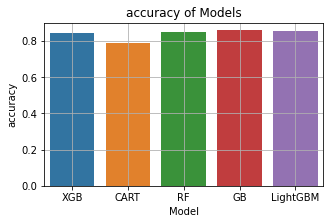

accuracy : {'XGB': 0.8455, 'CART': 0.7866000000000001, 'RF': 0.8504999999999999, 'GB': 0.8576, 'LightGBM': 0.8537000000000001}
-----------


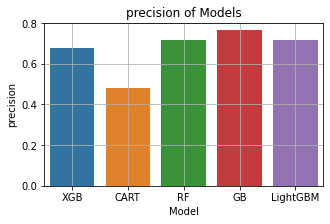

precision : {'XGB': 0.6750782089767504, 'CART': 0.47915322413471884, 'RF': 0.7175186560595535, 'GB': 0.7634652047977694, 'LightGBM': 0.7165543536955493}
-----------


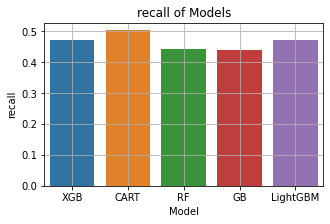

recall : {'XGB': 0.4715866053022676, 'CART': 0.5024521789155759, 'RF': 0.4422299726736661, 'GB': 0.4392911932499161, 'LightGBM': 0.4716069802003931}
-----------


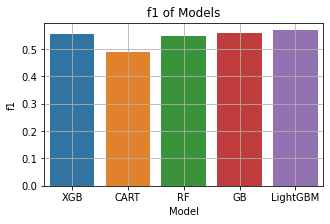

f1 : {'XGB': 0.554883665597958, 'CART': 0.49030812456992673, 'RF': 0.5468237897090057, 'GB': 0.5573022340997948, 'LightGBM': 0.5681556423631837}
-----------


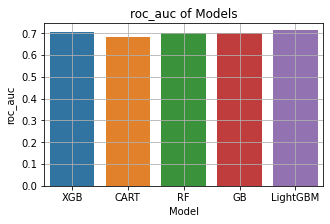

roc_auc : {'XGB': 0.7065148393099149, 'CART': 0.6809835347609854, 'RF': 0.6987478078927584, 'GB': 0.7021163649859332, 'LightGBM': 0.7116773597627772}
-----------


In [19]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

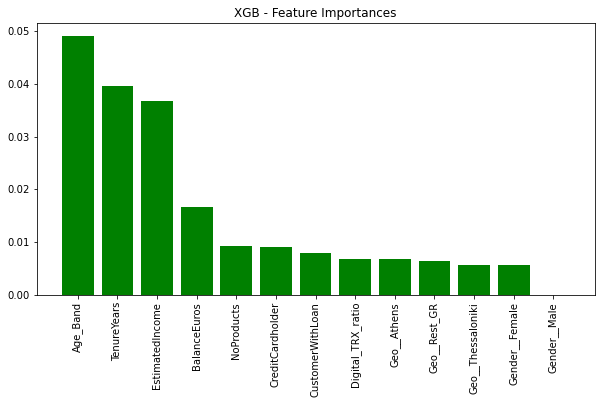

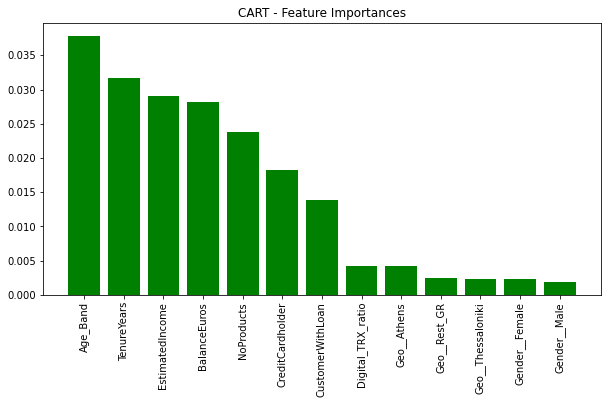

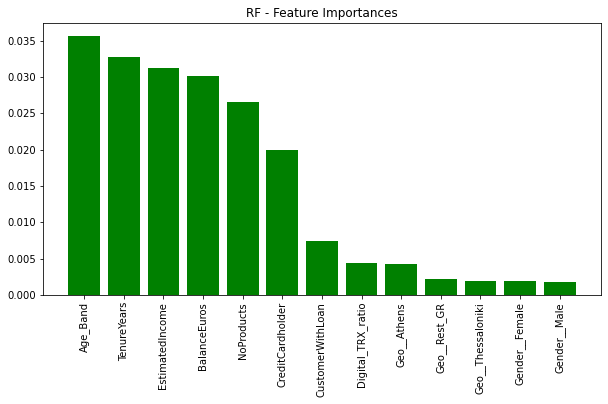

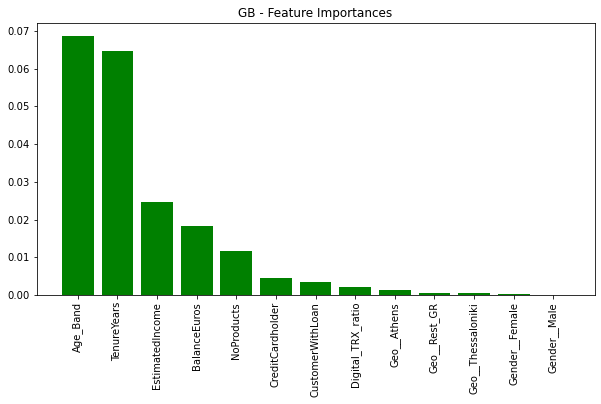

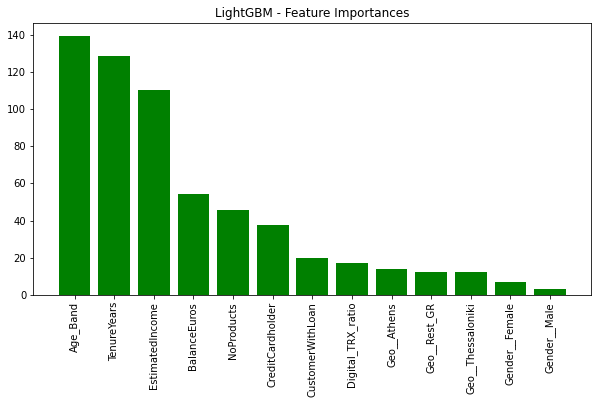

In [17]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [18]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.846 (0.005)
>CART 0.787 (0.007)
>RF 0.850 (0.004)
>GB 0.858 (0.004)
>LightGBM 0.854 (0.004)


### By removing Gender and Geography which have low feature importance, all metrics were reduced !!!

### Add more features - Feature engineering

In [41]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Geo__Athens', 'Geo__Rest_GR', 'Geo__Thessaloniki',
       'Gender__Female', 'Gender__Male', 'Inactive'],
      dtype='object')

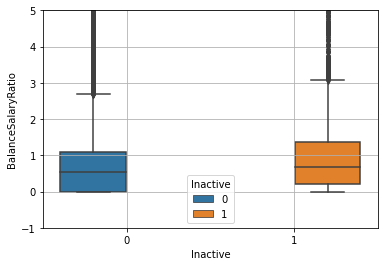

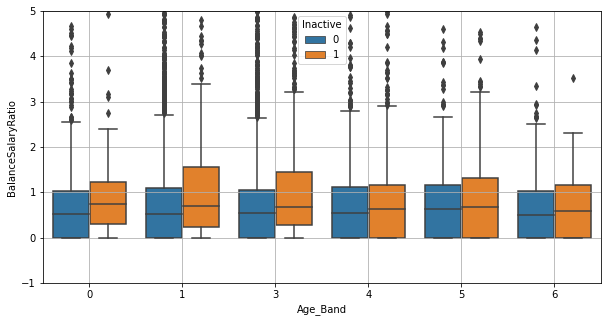

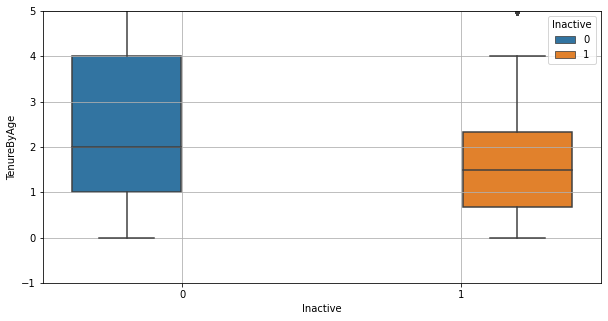

In [42]:
# 1st Attribute - Balance Salary Ratio
df['BalanceSalaryRatio'] = df.BalanceEuros/df.EstimatedIncome
sns.boxplot(y='BalanceSalaryRatio',x = 'Inactive', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

plt.figure(figsize=(10, 5))
sns.boxplot(y='BalanceSalaryRatio',x = 'Age_Band', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

plt.figure(figsize=(10, 5))
df['TenureByAge'] = df.TenureYears/(df.Age_Band)

df.dropna(inplace=True)
# drop infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

sns.boxplot(y='TenureByAge',x = 'Inactive', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

### Inactive customers have slightly larger Balance to Salary ratio

In [43]:
X = df.drop(['Inactive'], axis=1)
X.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Geo__Athens', 'Geo__Rest_GR', 'Geo__Thessaloniki',
       'Gender__Female', 'Gender__Male', 'BalanceSalaryRatio', 'TenureByAge'],
      dtype='object')

In [44]:
X = df.drop(['Inactive'], axis=1)
# index of categorical features in X
categorical_features = [0,1,4,5,6,8,9,10,11,12]
# index of numerical features in X
numerical_features = [2,3,7,13,14]

features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(9411, 15) (9411,)


In [16]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    # print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    # print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

In [17]:
results

{'XGB': [0.8359001593202336,
  0.8336875664187035,
  0.8416578108395324,
  0.8554729011689692,
  0.8453772582359192],
 'CART': [0.7971322357939459,
  0.769394261424017,
  0.7832093517534537,
  0.7763018065887354,
  0.7853347502656748],
 'RF': [0.8422729686670207,
  0.8320935175345378,
  0.8501594048884166,
  0.8549415515409139,
  0.8522848034006376],
 'GB': [0.8449283058948487,
  0.8469713071200851,
  0.8570669500531349,
  0.8645058448459086,
  0.8538788522848034],
 'LightGBM': [0.847052575677111,
  0.8416578108395324,
  0.8560042507970245,
  0.8634431455897981,
  0.8570669500531349]}

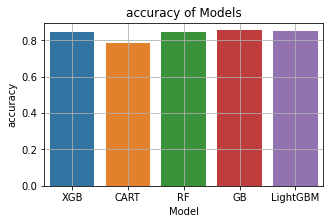

accuracy : {'XGB': 0.8424191391966716, 'CART': 0.7822744811651654, 'RF': 0.8463504492063054, 'GB': 0.8534702520397561, 'LightGBM': 0.8530449465913202}
-----------


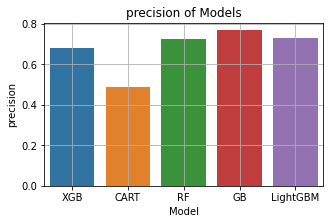

precision : {'XGB': 0.6824227232925065, 'CART': 0.4879053535660415, 'RF': 0.7245616412011786, 'GB': 0.7675872524082188, 'LightGBM': 0.7317134357452503}
-----------


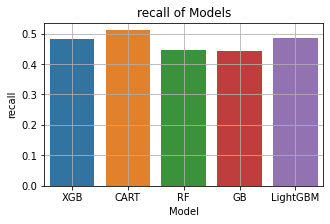

recall : {'XGB': 0.4822305764411028, 'CART': 0.5102719298245614, 'RF': 0.44618922305764414, 'GB': 0.4441804511278195, 'LightGBM': 0.4862431077694235}
-----------


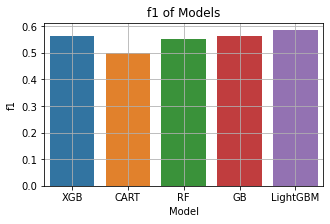

f1 : {'XGB': 0.5647923900845511, 'CART': 0.4987547776886931, 'RF': 0.5521318355375262, 'GB': 0.5625176651146211, 'LightGBM': 0.5841446820645412}
-----------


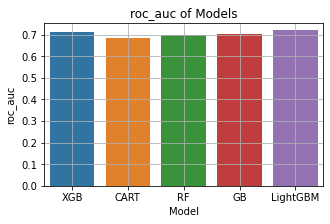

roc_auc : {'XGB': 0.7108344081064739, 'CART': 0.6829071603681125, 'RF': 0.700164198198437, 'GB': 0.7039486789487854, 'LightGBM': 0.7190448610373904}
-----------


In [18]:
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

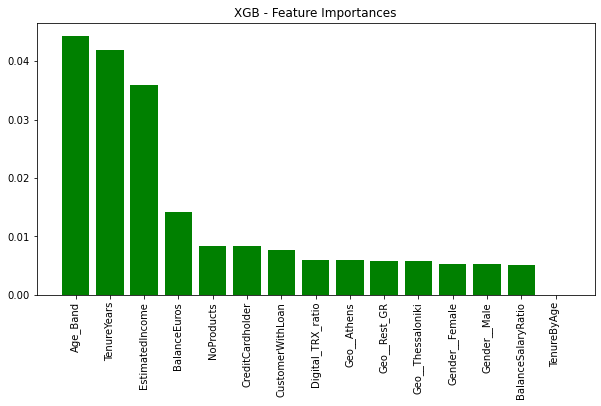

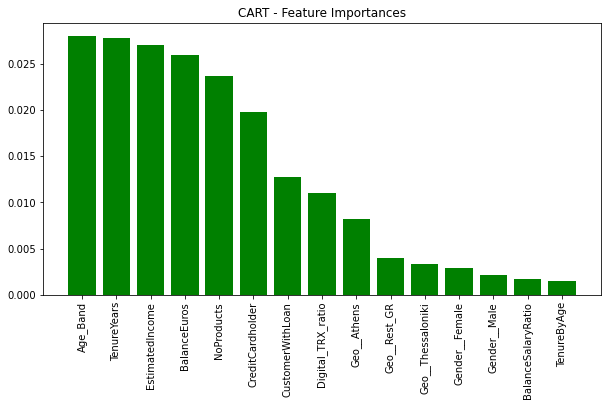

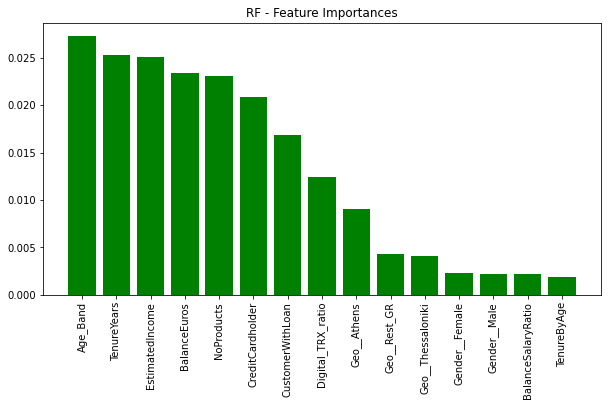

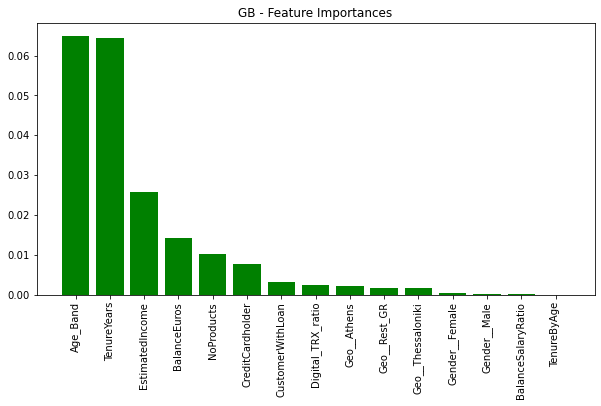

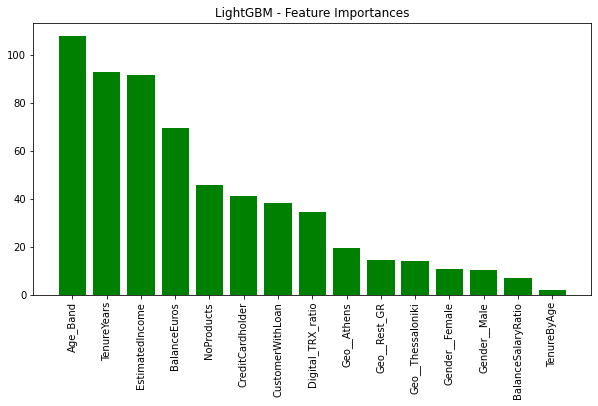

In [19]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [20]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.842 (0.008)
>CART 0.782 (0.009)
>RF 0.846 (0.008)
>GB 0.853 (0.007)
>LightGBM 0.853 (0.008)


In [21]:
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
print('ROC_AUC: ', roc_auc)

Accuracy:  {'XGB': 0.8424191391966716, 'CART': 0.7822744811651654, 'RF': 0.8463504492063054, 'GB': 0.8534702520397561, 'LightGBM': 0.8530449465913202}
Precision:  {'XGB': 0.6824227232925065, 'CART': 0.4879053535660415, 'RF': 0.7245616412011786, 'GB': 0.7675872524082188, 'LightGBM': 0.7317134357452503}
Recall:  {'XGB': 0.4822305764411028, 'CART': 0.5102719298245614, 'RF': 0.44618922305764414, 'GB': 0.4441804511278195, 'LightGBM': 0.4862431077694235}
F1:  {'XGB': 0.5647923900845511, 'CART': 0.4987547776886931, 'RF': 0.5521318355375262, 'GB': 0.5625176651146211, 'LightGBM': 0.5841446820645412}
ROC_AUC:  {'XGB': 0.7108344081064739, 'CART': 0.6829071603681125, 'RF': 0.700164198198437, 'GB': 0.7039486789487854, 'LightGBM': 0.7190448610373904}


### Optuna optimization of LightGBM algorithm (Best model)

In [19]:
import optuna
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    """
    Objective function to be minimized.
    """
    params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
    'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
    'subsample_freq': trial.suggest_loguniform('subsample_freq', 0.4, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 256),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1_scores = []
    roc_auc_scores = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        # if to_print_shapes:
            # print the number of unique label values
            # train_unique, train_counts = np.unique(train_y, return_counts=True)
            # test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        gbm = LGBMClassifier(**params)
        gbm.fit(train_X,train_y)
        preds = gbm.predict(test_X)
        f1 = f1_score(test_y, preds)
        f1_scores.append(f1)
        roc_auc = roc_auc_score(test_y, preds)
        roc_auc_scores.append(roc_auc)

    
    f1_scores = np.mean(f1_scores)  
    roc_auc_scores = np.mean(roc_auc_scores)   

    return roc_auc_scores

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

[I 2023-09-06 19:41:41,975] A new study created in memory with name: no-name-39b37c4a-6109-484f-9ded-fbb6b7dc0307
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample_freq': trial.suggest_loguniform('subsample_freq', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.7726448720542267, subsample=0.40538636051157084 will be ignored. Current value: bagging_fraction=0.7726448720542267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8957891119314199 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7726448720542267, subsample=0.40538636051157084 will be ignored. Current value: bagging_fraction=0.7726448720542267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8957891119314199 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7726448720542267, subsample=0.40538636051157084 will be ignored. Current value: bagging_fraction=0.7726448720542267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8957891119314199 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7726448720542267, subsample=0.40538636051157084 will be ignored. Current value: bagging_f

[I 2023-09-06 19:41:43,885] Trial 0 finished with value: 0.6556674247278552 and parameters: {'learning_rate': 0.014, 'subsample': 0.40538636051157084, 'subsample_freq': 0.8957891119314199, 'colsample_bytree': 0.8884331819660416, 'reg_alpha': 0.007635010412850234, 'reg_lambda': 0.012140914982815979, 'min_child_weight': 138, 'min_child_samples': 26, 'bagging_fraction': 0.7726448720542267, 'bagging_freq': 3}. Best is trial 0 with value: 0.6556674247278552.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.4987328800308485, subsample=0.9746537092974829 will be ignored. Current value: bagging_fraction=0.4987328800308485
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7183268908022554 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4987328800308485, subsample=0.9746537092974829 will be ignored. Current value: bagging_fraction=0.4987328800308485
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7183268908022554 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4987328800308485, subsample=0.9746537092974829 will be ignored. Current value: bagging_fraction=0.4987328800308485
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7183268908022554 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4987328800308485, subsample=0.9746537092974829 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:41:47,512] Trial 1 finished with value: 0.716116257238875 and parameters: {'learning_rate': 0.014, 'subsample': 0.9746537092974829, 'subsample_freq': 0.7183268908022554, 'colsample_bytree': 0.8875055815345334, 'reg_alpha': 0.09908473187561587, 'reg_lambda': 0.06087440605048518, 'min_child_weight': 18, 'min_child_samples': 16, 'bagging_fraction': 0.4987328800308485, 'bagging_freq': 5}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[LightGBM] [Warning] bagging_fraction is set=0.9371743580464071, subsample=0.4478132172288252 will be ignored. Current value: bagging_fraction=0.9371743580464071
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43972937960678177 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9371743580464071, subsample=0.4478132172288252 will be ignored. Current value: bagging_fraction=0.9371743580464071
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43972937960678177 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9371743580464071, subsample=0.4478132172288252 will be ignored. Current value: bagging_fraction=0.9371743580464071
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43972937960678177 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9371743580464071, subsample=0.4478132172288252 will be ignored. Current value: bagging_fr

[I 2023-09-06 19:41:49,874] Trial 2 finished with value: 0.654337883162962 and parameters: {'learning_rate': 0.017, 'subsample': 0.4478132172288252, 'subsample_freq': 0.43972937960678177, 'colsample_bytree': 0.6702859191041877, 'reg_alpha': 1.1993547182276088, 'reg_lambda': 1.5171366383950817, 'min_child_weight': 133, 'min_child_samples': 79, 'bagging_fraction': 0.9371743580464071, 'bagging_freq': 3}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[LightGBM] [Warning] bagging_fraction is set=0.9656495947881552, subsample=0.571229328791587 will be ignored. Current value: bagging_fraction=0.9656495947881552
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6383967682192238 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9656495947881552, subsample=0.571229328791587 will be ignored. Current value: bagging_fraction=0.9656495947881552
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6383967682192238 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9656495947881552, subsample=0.571229328791587 will be ignored. Current value: bagging_fraction=0.9656495947881552
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6383967682192238 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9656495947881552, subsample=0.571229328791587 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:41:51,757] Trial 3 finished with value: 0.6420990093887138 and parameters: {'learning_rate': 0.01, 'subsample': 0.571229328791587, 'subsample_freq': 0.6383967682192238, 'colsample_bytree': 0.47019623006573563, 'reg_alpha': 0.8331593012536676, 'reg_lambda': 0.6795436965216861, 'min_child_weight': 192, 'min_child_samples': 80, 'bagging_fraction': 0.9656495947881552, 'bagging_freq': 4}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[LightGBM] [Warning] bagging_fraction is set=0.548321800854092, subsample=0.548470381691993 will be ignored. Current value: bagging_fraction=0.548321800854092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.46844420794375496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.548321800854092, subsample=0.548470381691993 will be ignored. Current value: bagging_fraction=0.548321800854092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.46844420794375496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.548321800854092, subsample=0.548470381691993 will be ignored. Current value: bagging_fraction=0.548321800854092
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.46844420794375496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.548321800854092, subsample=0.548470381691993 will be ignored. Current value: bagging_fraction=0.54

[I 2023-09-06 19:41:53,201] Trial 4 finished with value: 0.6423398704045242 and parameters: {'learning_rate': 0.02, 'subsample': 0.548470381691993, 'subsample_freq': 0.46844420794375496, 'colsample_bytree': 0.5088253492070414, 'reg_alpha': 0.023548553101986475, 'reg_lambda': 0.0013804559883048085, 'min_child_weight': 150, 'min_child_samples': 99, 'bagging_fraction': 0.548321800854092, 'bagging_freq': 1}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.8342276532548645, subsample=0.4357719822466926 will be ignored. Current value: bagging_fraction=0.8342276532548645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6329326943902006 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8342276532548645, subsample=0.4357719822466926 will be ignored. Current value: bagging_fraction=0.8342276532548645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6329326943902006 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8342276532548645, subsample=0.4357719822466926 will be ignored. Current value: bagging_fraction=0.8342276532548645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6329326943902006 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8342276532548645, subsample=0.4357719822466926 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:41:55,604] Trial 5 finished with value: 0.6647615943874416 and parameters: {'learning_rate': 0.02, 'subsample': 0.4357719822466926, 'subsample_freq': 0.6329326943902006, 'colsample_bytree': 0.7879514056804899, 'reg_alpha': 0.25144383925024955, 'reg_lambda': 0.8693162438670079, 'min_child_weight': 81, 'min_child_samples': 58, 'bagging_fraction': 0.8342276532548645, 'bagging_freq': 5}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[LightGBM] [Warning] bagging_fraction is set=0.48596699550893446, subsample=0.992612394949606 will be ignored. Current value: bagging_fraction=0.48596699550893446
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.4166226852054685 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.48596699550893446, subsample=0.992612394949606 will be ignored. Current value: bagging_fraction=0.48596699550893446
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.4166226852054685 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.48596699550893446, subsample=0.992612394949606 will be ignored. Current value: bagging_fraction=0.48596699550893446
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.4166226852054685 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.48596699550893446, subsample=0.992612394949606 will be ignored. Current value: bagging_fr

[I 2023-09-06 19:41:57,682] Trial 6 finished with value: 0.6433840010706782 and parameters: {'learning_rate': 0.006, 'subsample': 0.992612394949606, 'subsample_freq': 0.4166226852054685, 'colsample_bytree': 0.8484909683496004, 'reg_alpha': 3.033030860323412, 'reg_lambda': 0.6908483971637858, 'min_child_weight': 61, 'min_child_samples': 82, 'bagging_fraction': 0.48596699550893446, 'bagging_freq': 6}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea

[LightGBM] [Warning] bagging_fraction is set=0.4152241521551466, subsample=0.534782371552805 will be ignored. Current value: bagging_fraction=0.4152241521551466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.9541201670414724 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4152241521551466, subsample=0.534782371552805 will be ignored. Current value: bagging_fraction=0.4152241521551466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.9541201670414724 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4152241521551466, subsample=0.534782371552805 will be ignored. Current value: bagging_fraction=0.4152241521551466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.9541201670414724 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4152241521551466, subsample=0.534782371552805 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:41:58,952] Trial 7 finished with value: 0.5382070489193055 and parameters: {'learning_rate': 0.02, 'subsample': 0.534782371552805, 'subsample_freq': 0.9541201670414724, 'colsample_bytree': 0.47392172406188465, 'reg_alpha': 0.014032118191073495, 'reg_lambda': 0.0036741184329641477, 'min_child_weight': 207, 'min_child_samples': 15, 'bagging_fraction': 0.4152241521551466, 'bagging_freq': 4}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5157360364908469, subsample=0.7450680825904058 will be ignored. Current value: bagging_fraction=0.5157360364908469
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5503018018842686 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5157360364908469, subsample=0.7450680825904058 will be ignored. Current value: bagging_fraction=0.5157360364908469
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5503018018842686 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5157360364908469, subsample=0.7450680825904058 will be ignored. Current value: bagging_fraction=0.5157360364908469
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5503018018842686 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5157360364908469, subsample=0.7450680825904058 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:00,420] Trial 8 finished with value: 0.6505329546504884 and parameters: {'learning_rate': 0.017, 'subsample': 0.7450680825904058, 'subsample_freq': 0.5503018018842686, 'colsample_bytree': 0.42150729668442133, 'reg_alpha': 4.992833508465929, 'reg_lambda': 0.0022747281621000866, 'min_child_weight': 82, 'min_child_samples': 39, 'bagging_fraction': 0.5157360364908469, 'bagging_freq': 5}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.8094891188832456, subsample=0.6485753354200354 will be ignored. Current value: bagging_fraction=0.8094891188832456
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.8643276427949417 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8094891188832456, subsample=0.6485753354200354 will be ignored. Current value: bagging_fraction=0.8094891188832456
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.8643276427949417 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8094891188832456, subsample=0.6485753354200354 will be ignored. Current value: bagging_fraction=0.8094891188832456
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.8643276427949417 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8094891188832456, subsample=0.6485753354200354 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:02,247] Trial 9 finished with value: 0.6583357729091129 and parameters: {'learning_rate': 0.014, 'subsample': 0.6485753354200354, 'subsample_freq': 0.8643276427949417, 'colsample_bytree': 0.968227732328768, 'reg_alpha': 0.007141139929635583, 'reg_lambda': 0.12167761887781438, 'min_child_weight': 145, 'min_child_samples': 15, 'bagging_fraction': 0.8094891188832456, 'bagging_freq': 5}. Best is trial 1 with value: 0.716116257238875.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6190458482897566, subsample=0.9663920387051115 will be ignored. Current value: bagging_fraction=0.6190458482897566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7506878286919835 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6190458482897566, subsample=0.9663920387051115 will be ignored. Current value: bagging_fraction=0.6190458482897566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7506878286919835 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6190458482897566, subsample=0.9663920387051115 will be ignored. Current value: bagging_fraction=0.6190458482897566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7506878286919835 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6190458482897566, subsample=0.9663920387051115 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:07,326] Trial 10 finished with value: 0.7220573707857485 and parameters: {'learning_rate': 0.008, 'subsample': 0.9663920387051115, 'subsample_freq': 0.7506878286919835, 'colsample_bytree': 0.9964688543397662, 'reg_alpha': 0.001490697169482939, 'reg_lambda': 0.04122177205388708, 'min_child_weight': 6, 'min_child_samples': 6, 'bagging_fraction': 0.6190458482897566, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6341990248383215, subsample=0.9549896917468453 will be ignored. Current value: bagging_fraction=0.6341990248383215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7512572535567059 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6341990248383215, subsample=0.9549896917468453 will be ignored. Current value: bagging_fraction=0.6341990248383215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7512572535567059 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6341990248383215, subsample=0.9549896917468453 will be ignored. Current value: bagging_fraction=0.6341990248383215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7512572535567059 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6341990248383215, subsample=0.9549896917468453 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:12,102] Trial 11 finished with value: 0.7178718821341439 and parameters: {'learning_rate': 0.014, 'subsample': 0.9549896917468453, 'subsample_freq': 0.7512572535567059, 'colsample_bytree': 0.9962688599646395, 'reg_alpha': 0.0012920934963444456, 'reg_lambda': 0.04183661837318533, 'min_child_weight': 5, 'min_child_samples': 5, 'bagging_fraction': 0.6341990248383215, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6525007020708142, subsample=0.877327362998014 will be ignored. Current value: bagging_fraction=0.6525007020708142
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7367587423732767 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6525007020708142, subsample=0.877327362998014 will be ignored. Current value: bagging_fraction=0.6525007020708142
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7367587423732767 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6525007020708142, subsample=0.877327362998014 will be ignored. Current value: bagging_fraction=0.6525007020708142
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7367587423732767 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6525007020708142, subsample=0.877327362998014 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:42:16,682] Trial 12 finished with value: 0.7186606258371173 and parameters: {'learning_rate': 0.008, 'subsample': 0.877327362998014, 'subsample_freq': 0.7367587423732767, 'colsample_bytree': 0.9970196970290108, 'reg_alpha': 0.0011728015199992867, 'reg_lambda': 9.820351998766343, 'min_child_weight': 6, 'min_child_samples': 5, 'bagging_fraction': 0.6525007020708142, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

[LightGBM] [Warning] bagging_fraction is set=0.6539493551426222, subsample=0.8387494529121958 will be ignored. Current value: bagging_fraction=0.6539493551426222
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7583439737534559 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6539493551426222, subsample=0.8387494529121958 will be ignored. Current value: bagging_fraction=0.6539493551426222
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7583439737534559 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6539493551426222, subsample=0.8387494529121958 will be ignored. Current value: bagging_fraction=0.6539493551426222
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7583439737534559 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6539493551426222, subsample=0.8387494529121958 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:19,858] Trial 13 finished with value: 0.6606206735912347 and parameters: {'learning_rate': 0.008, 'subsample': 0.8387494529121958, 'subsample_freq': 0.7583439737534559, 'colsample_bytree': 0.9645984401865143, 'reg_alpha': 0.001339763776670514, 'reg_lambda': 8.14481939930769, 'min_child_weight': 46, 'min_child_samples': 39, 'bagging_fraction': 0.6539493551426222, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6991839087377408, subsample=0.8301219716359037 will be ignored. Current value: bagging_fraction=0.6991839087377408
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8171183151266266 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6991839087377408, subsample=0.8301219716359037 will be ignored. Current value: bagging_fraction=0.6991839087377408
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8171183151266266 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6991839087377408, subsample=0.8301219716359037 will be ignored. Current value: bagging_fraction=0.6991839087377408
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8171183151266266 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6991839087377408, subsample=0.8301219716359037 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:23,109] Trial 14 finished with value: 0.6603693749584814 and parameters: {'learning_rate': 0.008, 'subsample': 0.8301219716359037, 'subsample_freq': 0.8171183151266266, 'colsample_bytree': 0.753314023081886, 'reg_alpha': 0.0010515005353699794, 'reg_lambda': 8.204187081980198, 'min_child_weight': 36, 'min_child_samples': 35, 'bagging_fraction': 0.6991839087377408, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6067551936348491, subsample=0.8489438612704945 will be ignored. Current value: bagging_fraction=0.6067551936348491
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6878010955087915 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6067551936348491, subsample=0.8489438612704945 will be ignored. Current value: bagging_fraction=0.6067551936348491
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6878010955087915 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6067551936348491, subsample=0.8489438612704945 will be ignored. Current value: bagging_fraction=0.6067551936348491
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6878010955087915 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6067551936348491, subsample=0.8489438612704945 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:24,278] Trial 15 finished with value: 0.5297208283429671 and parameters: {'learning_rate': 0.008, 'subsample': 0.8489438612704945, 'subsample_freq': 0.6878010955087915, 'colsample_bytree': 0.9928306163305121, 'reg_alpha': 0.00334107386835194, 'reg_lambda': 0.15372749778736713, 'min_child_weight': 246, 'min_child_samples': 55, 'bagging_fraction': 0.6067551936348491, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.7422029593566333, subsample=0.7295773031406598 will be ignored. Current value: bagging_fraction=0.7422029593566333
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.8039168419978778 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7422029593566333, subsample=0.7295773031406598 will be ignored. Current value: bagging_fraction=0.7422029593566333
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.8039168419978778 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7422029593566333, subsample=0.7295773031406598 will be ignored. Current value: bagging_fraction=0.7422029593566333
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.8039168419978778 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7422029593566333, subsample=0.7295773031406598 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:26,310] Trial 16 finished with value: 0.65281536993191 and parameters: {'learning_rate': 0.008, 'subsample': 0.7295773031406598, 'subsample_freq': 0.8039168419978778, 'colsample_bytree': 0.9258733089213901, 'reg_alpha': 0.03529507462038784, 'reg_lambda': 0.01903235272405947, 'min_child_weight': 101, 'min_child_samples': 5, 'bagging_fraction': 0.7422029593566333, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.5834529965150235, subsample=0.8666863777601738 will be ignored. Current value: bagging_fraction=0.5834529965150235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5769046366113805 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5834529965150235, subsample=0.8666863777601738 will be ignored. Current value: bagging_fraction=0.5834529965150235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5769046366113805 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5834529965150235, subsample=0.8666863777601738 will be ignored. Current value: bagging_fraction=0.5834529965150235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5769046366113805 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5834529965150235, subsample=0.8666863777601738 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:31,790] Trial 17 finished with value: 0.7205585784186594 and parameters: {'learning_rate': 0.008, 'subsample': 0.8666863777601738, 'subsample_freq': 0.5769046366113805, 'colsample_bytree': 0.8446117171159586, 'reg_alpha': 0.0032793705662977775, 'reg_lambda': 0.31671126168655106, 'min_child_weight': 7, 'min_child_samples': 26, 'bagging_fraction': 0.5834529965150235, 'bagging_freq': 1}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.569500700973563, subsample=0.7621326858679544 will be ignored. Current value: bagging_fraction=0.569500700973563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5335773502827782 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.569500700973563, subsample=0.7621326858679544 will be ignored. Current value: bagging_fraction=0.569500700973563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5335773502827782 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.569500700973563, subsample=0.7621326858679544 will be ignored. Current value: bagging_fraction=0.569500700973563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5335773502827782 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.569500700973563, subsample=0.7621326858679544 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-06 19:42:34,857] Trial 18 finished with value: 0.6636516992400603 and parameters: {'learning_rate': 0.01, 'subsample': 0.7621326858679544, 'subsample_freq': 0.5335773502827782, 'colsample_bytree': 0.8401542029604736, 'reg_alpha': 0.0044286440164116965, 'reg_lambda': 0.21306678868301124, 'min_child_weight': 39, 'min_child_samples': 27, 'bagging_fraction': 0.569500700973563, 'bagging_freq': 1}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5982767684743852, subsample=0.9108299765438772 will be ignored. Current value: bagging_fraction=0.5982767684743852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5798440957468044 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5982767684743852, subsample=0.9108299765438772 will be ignored. Current value: bagging_fraction=0.5982767684743852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5798440957468044 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5982767684743852, subsample=0.9108299765438772 will be ignored. Current value: bagging_fraction=0.5982767684743852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5798440957468044 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5982767684743852, subsample=0.9108299765438772 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:36,830] Trial 19 finished with value: 0.6364162262599284 and parameters: {'learning_rate': 0.006, 'subsample': 0.9108299765438772, 'subsample_freq': 0.5798440957468044, 'colsample_bytree': 0.6834852010614293, 'reg_alpha': 0.047652016681624686, 'reg_lambda': 0.007579988785278291, 'min_child_weight': 110, 'min_child_samples': 47, 'bagging_fraction': 0.5982767684743852, 'bagging_freq': 2}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

[LightGBM] [Warning] bagging_fraction is set=0.6966751775697457, subsample=0.9143658521989266 will be ignored. Current value: bagging_fraction=0.6966751775697457
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.661833588281036 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6966751775697457, subsample=0.9143658521989266 will be ignored. Current value: bagging_fraction=0.6966751775697457
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.661833588281036 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6966751775697457, subsample=0.9143658521989266 will be ignored. Current value: bagging_fraction=0.6966751775697457
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.661833588281036 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6966751775697457, subsample=0.9143658521989266 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:42:39,665] Trial 20 finished with value: 0.6596144534269955 and parameters: {'learning_rate': 0.008, 'subsample': 0.9143658521989266, 'subsample_freq': 0.661833588281036, 'colsample_bytree': 0.9114314847940639, 'reg_alpha': 0.01322601136239112, 'reg_lambda': 0.028319768604487528, 'min_child_weight': 60, 'min_child_samples': 25, 'bagging_fraction': 0.6966751775697457, 'bagging_freq': 2}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6524591895438933, subsample=0.8806065807590021 will be ignored. Current value: bagging_fraction=0.6524591895438933
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7061338558712593 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6524591895438933, subsample=0.8806065807590021 will be ignored. Current value: bagging_fraction=0.6524591895438933
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7061338558712593 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6524591895438933, subsample=0.8806065807590021 will be ignored. Current value: bagging_fraction=0.6524591895438933
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7061338558712593 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6524591895438933, subsample=0.8806065807590021 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:45,329] Trial 21 finished with value: 0.7186117108542402 and parameters: {'learning_rate': 0.008, 'subsample': 0.8806065807590021, 'subsample_freq': 0.7061338558712593, 'colsample_bytree': 0.9314769000979638, 'reg_alpha': 0.0030118524080843985, 'reg_lambda': 3.6872379906232373, 'min_child_weight': 9, 'min_child_samples': 12, 'bagging_fraction': 0.6524591895438933, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.558937648362544, subsample=0.7987578123320771 will be ignored. Current value: bagging_fraction=0.558937648362544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5806767318512279 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.558937648362544, subsample=0.7987578123320771 will be ignored. Current value: bagging_fraction=0.558937648362544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5806767318512279 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.558937648362544, subsample=0.7987578123320771 will be ignored. Current value: bagging_fraction=0.558937648362544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5806767318512279 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.558937648362544, subsample=0.7987578123320771 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-06 19:42:49,189] Trial 22 finished with value: 0.7118404291760575 and parameters: {'learning_rate': 0.008, 'subsample': 0.7987578123320771, 'subsample_freq': 0.5806767318512279, 'colsample_bytree': 0.9989397941003996, 'reg_alpha': 0.002350967456733926, 'reg_lambda': 0.2938417888805635, 'min_child_weight': 19, 'min_child_samples': 5, 'bagging_fraction': 0.558937648362544, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6609262532095013, subsample=0.9975338848778477 will be ignored. Current value: bagging_fraction=0.6609262532095013
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7657675326846526 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6609262532095013, subsample=0.9975338848778477 will be ignored. Current value: bagging_fraction=0.6609262532095013
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7657675326846526 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6609262532095013, subsample=0.9975338848778477 will be ignored. Current value: bagging_fraction=0.6609262532095013
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7657675326846526 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6609262532095013, subsample=0.9975338848778477 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:53,030] Trial 23 finished with value: 0.6626788744905471 and parameters: {'learning_rate': 0.008, 'subsample': 0.9975338848778477, 'subsample_freq': 0.7657675326846526, 'colsample_bytree': 0.9406763521714019, 'reg_alpha': 0.001036428674934577, 'reg_lambda': 0.06417341032394465, 'min_child_weight': 38, 'min_child_samples': 24, 'bagging_fraction': 0.6609262532095013, 'bagging_freq': 2}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6077481848004169, subsample=0.9026930235083582 will be ignored. Current value: bagging_fraction=0.6077481848004169
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6764944254420882 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6077481848004169, subsample=0.9026930235083582 will be ignored. Current value: bagging_fraction=0.6077481848004169
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6764944254420882 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6077481848004169, subsample=0.9026930235083582 will be ignored. Current value: bagging_fraction=0.6077481848004169
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6764944254420882 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6077481848004169, subsample=0.9026930235083582 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:42:56,048] Trial 24 finished with value: 0.6535754644144467 and parameters: {'learning_rate': 0.008, 'subsample': 0.9026930235083582, 'subsample_freq': 0.6764944254420882, 'colsample_bytree': 0.8567708431353737, 'reg_alpha': 0.002438614674975103, 'reg_lambda': 2.5488374513736396, 'min_child_weight': 66, 'min_child_samples': 16, 'bagging_fraction': 0.6077481848004169, 'bagging_freq': 3}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.7184099532365469, subsample=0.7919074169887176 will be ignored. Current value: bagging_fraction=0.7184099532365469
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9711106962445819 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7184099532365469, subsample=0.7919074169887176 will be ignored. Current value: bagging_fraction=0.7184099532365469
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9711106962445819 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7184099532365469, subsample=0.7919074169887176 will be ignored. Current value: bagging_fraction=0.7184099532365469
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9711106962445819 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7184099532365469, subsample=0.7919074169887176 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:13,256] Trial 25 finished with value: 0.7152419032240075 and parameters: {'learning_rate': 0.008, 'subsample': 0.7919074169887176, 'subsample_freq': 0.9711106962445819, 'colsample_bytree': 0.9449155057563067, 'reg_alpha': 0.005262224118644394, 'reg_lambda': 0.22172031679973606, 'min_child_weight': 28, 'min_child_samples': 33, 'bagging_fraction': 0.7184099532365469, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6027719797199669, subsample=0.7039687031478303 will be ignored. Current value: bagging_fraction=0.6027719797199669
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7177389146669355 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6027719797199669, subsample=0.7039687031478303 will be ignored. Current value: bagging_fraction=0.6027719797199669
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7177389146669355 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6027719797199669, subsample=0.7039687031478303 will be ignored. Current value: bagging_fraction=0.6027719797199669
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7177389146669355 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6027719797199669, subsample=0.7039687031478303 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:18,616] Trial 26 finished with value: 0.7187389142691784 and parameters: {'learning_rate': 0.008, 'subsample': 0.7039687031478303, 'subsample_freq': 0.7177389146669355, 'colsample_bytree': 0.8925344107605183, 'reg_alpha': 0.0020274158276798273, 'reg_lambda': 0.09344252585473058, 'min_child_weight': 8, 'min_child_samples': 46, 'bagging_fraction': 0.6027719797199669, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5836545778734683, subsample=0.6894388927039707 will be ignored. Current value: bagging_fraction=0.5836545778734683
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6072391975951735 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5836545778734683, subsample=0.6894388927039707 will be ignored. Current value: bagging_fraction=0.5836545778734683
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6072391975951735 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5836545778734683, subsample=0.6894388927039707 will be ignored. Current value: bagging_fraction=0.5836545778734683
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6072391975951735 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5836545778734683, subsample=0.6894388927039707 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:19,937] Trial 27 finished with value: 0.6420516764705997 and parameters: {'learning_rate': 0.017, 'subsample': 0.6894388927039707, 'subsample_freq': 0.6072391975951735, 'colsample_bytree': 0.802235391660003, 'reg_alpha': 0.010622094345623122, 'reg_lambda': 0.08075139641067007, 'min_child_weight': 169, 'min_child_samples': 63, 'bagging_fraction': 0.5836545778734683, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5352530255862213, subsample=0.7974217669319806 will be ignored. Current value: bagging_fraction=0.5352530255862213
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6576521269062108 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5352530255862213, subsample=0.7974217669319806 will be ignored. Current value: bagging_fraction=0.5352530255862213
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6576521269062108 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5352530255862213, subsample=0.7974217669319806 will be ignored. Current value: bagging_fraction=0.5352530255862213
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6576521269062108 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5352530255862213, subsample=0.7974217669319806 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:21,626] Trial 28 finished with value: 0.640779698806121 and parameters: {'learning_rate': 0.006, 'subsample': 0.7974217669319806, 'subsample_freq': 0.6576521269062108, 'colsample_bytree': 0.8830183053247619, 'reg_alpha': 0.005645249415071751, 'reg_lambda': 0.03403936233267959, 'min_child_weight': 100, 'min_child_samples': 44, 'bagging_fraction': 0.5352530255862213, 'bagging_freq': 4}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.46511533753861645, subsample=0.7068978710644255 will be ignored. Current value: bagging_fraction=0.46511533753861645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8825508618163153 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.46511533753861645, subsample=0.7068978710644255 will be ignored. Current value: bagging_fraction=0.46511533753861645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8825508618163153 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.46511533753861645, subsample=0.7068978710644255 will be ignored. Current value: bagging_fraction=0.46511533753861645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8825508618163153 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.46511533753861645, subsample=0.7068978710644255 will be ignored. Current value: baggin

[I 2023-09-06 19:43:24,062] Trial 29 finished with value: 0.6568862170793445 and parameters: {'learning_rate': 0.01, 'subsample': 0.7068978710644255, 'subsample_freq': 0.8825508618163153, 'colsample_bytree': 0.9113709660754519, 'reg_alpha': 0.008342041850990599, 'reg_lambda': 0.010364203875502173, 'min_child_weight': 53, 'min_child_samples': 65, 'bagging_fraction': 0.46511533753861645, 'bagging_freq': 1}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.5436232108810815, subsample=0.9491114201107945 will be ignored. Current value: bagging_fraction=0.5436232108810815
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8078000188515848 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5436232108810815, subsample=0.9491114201107945 will be ignored. Current value: bagging_fraction=0.5436232108810815
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8078000188515848 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5436232108810815, subsample=0.9491114201107945 will be ignored. Current value: bagging_fraction=0.5436232108810815
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8078000188515848 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5436232108810815, subsample=0.9491114201107945 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:26,127] Trial 30 finished with value: 0.6496852156845768 and parameters: {'learning_rate': 0.008, 'subsample': 0.9491114201107945, 'subsample_freq': 0.8078000188515848, 'colsample_bytree': 0.8907195599242943, 'reg_alpha': 0.002184009786053334, 'reg_lambda': 0.33282763131081794, 'min_child_weight': 79, 'min_child_samples': 48, 'bagging_fraction': 0.5436232108810815, 'bagging_freq': 4}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6145592439543832, subsample=0.8607030786408163 will be ignored. Current value: bagging_fraction=0.6145592439543832
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.727530604949546 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6145592439543832, subsample=0.8607030786408163 will be ignored. Current value: bagging_fraction=0.6145592439543832
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.727530604949546 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6145592439543832, subsample=0.8607030786408163 will be ignored. Current value: bagging_fraction=0.6145592439543832
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.727530604949546 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6145592439543832, subsample=0.8607030786408163 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:43:31,401] Trial 31 finished with value: 0.7201367758508777 and parameters: {'learning_rate': 0.008, 'subsample': 0.8607030786408163, 'subsample_freq': 0.727530604949546, 'colsample_bytree': 0.9573310669912372, 'reg_alpha': 0.0019281981158906275, 'reg_lambda': 0.114051147717109, 'min_child_weight': 5, 'min_child_samples': 21, 'bagging_fraction': 0.6145592439543832, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6035323105107964, subsample=0.8487543689767428 will be ignored. Current value: bagging_fraction=0.6035323105107964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6880789323484909 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6035323105107964, subsample=0.8487543689767428 will be ignored. Current value: bagging_fraction=0.6035323105107964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6880789323484909 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6035323105107964, subsample=0.8487543689767428 will be ignored. Current value: bagging_fraction=0.6035323105107964
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6880789323484909 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6035323105107964, subsample=0.8487543689767428 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:38,722] Trial 32 finished with value: 0.7144522286576444 and parameters: {'learning_rate': 0.008, 'subsample': 0.8487543689767428, 'subsample_freq': 0.6880789323484909, 'colsample_bytree': 0.9549006688905125, 'reg_alpha': 0.0020717310029564552, 'reg_lambda': 0.10253803216635832, 'min_child_weight': 22, 'min_child_samples': 24, 'bagging_fraction': 0.6035323105107964, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.5163563606203458, subsample=0.9270435537101118 will be ignored. Current value: bagging_fraction=0.5163563606203458
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7509655293648873 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5163563606203458, subsample=0.9270435537101118 will be ignored. Current value: bagging_fraction=0.5163563606203458
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7509655293648873 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5163563606203458, subsample=0.9270435537101118 will be ignored. Current value: bagging_fraction=0.5163563606203458
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7509655293648873 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5163563606203458, subsample=0.9270435537101118 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:43:49,623] Trial 33 finished with value: 0.660077957192634 and parameters: {'learning_rate': 0.008, 'subsample': 0.9270435537101118, 'subsample_freq': 0.7509655293648873, 'colsample_bytree': 0.8868127699221514, 'reg_alpha': 0.004181504752835134, 'reg_lambda': 0.07033444073281049, 'min_child_weight': 27, 'min_child_samples': 32, 'bagging_fraction': 0.5163563606203458, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6244452803761888, subsample=0.7694479498420139 will be ignored. Current value: bagging_fraction=0.6244452803761888
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7161523527339786 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6244452803761888, subsample=0.7694479498420139 will be ignored. Current value: bagging_fraction=0.6244452803761888
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7161523527339786 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6244452803761888, subsample=0.7694479498420139 will be ignored. Current value: bagging_fraction=0.6244452803761888
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7161523527339786 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6244452803761888, subsample=0.7694479498420139 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:00,338] Trial 34 finished with value: 0.7160511506215095 and parameters: {'learning_rate': 0.014, 'subsample': 0.7694479498420139, 'subsample_freq': 0.7161523527339786, 'colsample_bytree': 0.9153018807287171, 'reg_alpha': 0.001882889596444351, 'reg_lambda': 0.40087346069468727, 'min_child_weight': 20, 'min_child_samples': 20, 'bagging_fraction': 0.6244452803761888, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5783643626401275, subsample=0.9989527193737046 will be ignored. Current value: bagging_fraction=0.5783643626401275
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6298657755442133 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5783643626401275, subsample=0.9989527193737046 will be ignored. Current value: bagging_fraction=0.5783643626401275
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6298657755442133 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5783643626401275, subsample=0.9989527193737046 will be ignored. Current value: bagging_fraction=0.5783643626401275
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6298657755442133 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5783643626401275, subsample=0.9989527193737046 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:05,848] Trial 35 finished with value: 0.7212610075684569 and parameters: {'learning_rate': 0.008, 'subsample': 0.9989527193737046, 'subsample_freq': 0.6298657755442133, 'colsample_bytree': 0.8644284253025017, 'reg_alpha': 0.00364123400603853, 'reg_lambda': 0.14340165811565692, 'min_child_weight': 5, 'min_child_samples': 11, 'bagging_fraction': 0.5783643626401275, 'bagging_freq': 3}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.5681049613259652, subsample=0.9699154379493451 will be ignored. Current value: bagging_fraction=0.5681049613259652
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6261525491039857 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5681049613259652, subsample=0.9699154379493451 will be ignored. Current value: bagging_fraction=0.5681049613259652
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6261525491039857 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5681049613259652, subsample=0.9699154379493451 will be ignored. Current value: bagging_fraction=0.5681049613259652
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6261525491039857 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5681049613259652, subsample=0.9699154379493451 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:08,633] Trial 36 finished with value: 0.6649428193714225 and parameters: {'learning_rate': 0.017, 'subsample': 0.9699154379493451, 'subsample_freq': 0.6261525491039857, 'colsample_bytree': 0.8188372504324343, 'reg_alpha': 0.004379674499415692, 'reg_lambda': 0.047462603332197574, 'min_child_weight': 48, 'min_child_samples': 10, 'bagging_fraction': 0.5681049613259652, 'bagging_freq': 2}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.49998286464322955, subsample=0.9433750095228257 will be ignored. Current value: bagging_fraction=0.49998286464322955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5054200176855731 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49998286464322955, subsample=0.9433750095228257 will be ignored. Current value: bagging_fraction=0.49998286464322955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5054200176855731 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49998286464322955, subsample=0.9433750095228257 will be ignored. Current value: bagging_fraction=0.49998286464322955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5054200176855731 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49998286464322955, subsample=0.9433750095228257 will be ignored. Current value: baggin

[I 2023-09-06 19:44:12,057] Trial 37 finished with value: 0.6665375165050964 and parameters: {'learning_rate': 0.02, 'subsample': 0.9433750095228257, 'subsample_freq': 0.5054200176855731, 'colsample_bytree': 0.7682998881646954, 'reg_alpha': 0.017476830420528167, 'reg_lambda': 0.16875095921090655, 'min_child_weight': 32, 'min_child_samples': 20, 'bagging_fraction': 0.49998286464322955, 'bagging_freq': 3}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6808958022965604, subsample=0.9817987436959789 will be ignored. Current value: bagging_fraction=0.6808958022965604
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6508742110641254 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6808958022965604, subsample=0.9817987436959789 will be ignored. Current value: bagging_fraction=0.6808958022965604
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6508742110641254 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6808958022965604, subsample=0.9817987436959789 will be ignored. Current value: bagging_fraction=0.6808958022965604
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6508742110641254 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6808958022965604, subsample=0.9817987436959789 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:14,297] Trial 38 finished with value: 0.651438050882172 and parameters: {'learning_rate': 0.01, 'subsample': 0.9817987436959789, 'subsample_freq': 0.6508742110641254, 'colsample_bytree': 0.8632116716692931, 'reg_alpha': 0.008890268597104038, 'reg_lambda': 0.558764800669556, 'min_child_weight': 124, 'min_child_samples': 11, 'bagging_fraction': 0.6808958022965604, 'bagging_freq': 3}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6301382135430408, subsample=0.8804378818304113 will be ignored. Current value: bagging_fraction=0.6301382135430408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6163721739976371 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6301382135430408, subsample=0.8804378818304113 will be ignored. Current value: bagging_fraction=0.6301382135430408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6163721739976371 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6301382135430408, subsample=0.8804378818304113 will be ignored. Current value: bagging_fraction=0.6301382135430408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6163721739976371 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6301382135430408, subsample=0.8804378818304113 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:19,332] Trial 39 finished with value: 0.7146548398071271 and parameters: {'learning_rate': 0.008, 'subsample': 0.8804378818304113, 'subsample_freq': 0.6163721739976371, 'colsample_bytree': 0.7319942267000401, 'reg_alpha': 0.006383391669244884, 'reg_lambda': 0.022820601041408244, 'min_child_weight': 18, 'min_child_samples': 19, 'bagging_fraction': 0.6301382135430408, 'bagging_freq': 1}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.5696363424739151, subsample=0.9874822152513336 will be ignored. Current value: bagging_fraction=0.5696363424739151
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5941390883631895 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5696363424739151, subsample=0.9874822152513336 will be ignored. Current value: bagging_fraction=0.5696363424739151
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5941390883631895 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5696363424739151, subsample=0.9874822152513336 will be ignored. Current value: bagging_fraction=0.5696363424739151
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5941390883631895 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5696363424739151, subsample=0.9874822152513336 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:21,276] Trial 40 finished with value: 0.6437585162202668 and parameters: {'learning_rate': 0.006, 'subsample': 0.9874822152513336, 'subsample_freq': 0.5941390883631895, 'colsample_bytree': 0.8217086609101577, 'reg_alpha': 0.0032482702132522264, 'reg_lambda': 0.1251740091600143, 'min_child_weight': 70, 'min_child_samples': 29, 'bagging_fraction': 0.5696363424739151, 'bagging_freq': 5}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5765203140968731, subsample=0.9398440127318233 will be ignored. Current value: bagging_fraction=0.5765203140968731
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7004176262997777 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5765203140968731, subsample=0.9398440127318233 will be ignored. Current value: bagging_fraction=0.5765203140968731
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7004176262997777 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5765203140968731, subsample=0.9398440127318233 will be ignored. Current value: bagging_fraction=0.5765203140968731
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7004176262997777 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5765203140968731, subsample=0.9398440127318233 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:26,186] Trial 41 finished with value: 0.7173018226878468 and parameters: {'learning_rate': 0.008, 'subsample': 0.9398440127318233, 'subsample_freq': 0.7004176262997777, 'colsample_bytree': 0.8722494922534535, 'reg_alpha': 0.0020214101130862534, 'reg_lambda': 0.08692003394883853, 'min_child_weight': 5, 'min_child_samples': 11, 'bagging_fraction': 0.5765203140968731, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.532828766185155, subsample=0.8779462962942539 will be ignored. Current value: bagging_fraction=0.532828766185155
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6264108996453829 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.532828766185155, subsample=0.8779462962942539 will be ignored. Current value: bagging_fraction=0.532828766185155
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6264108996453829 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.532828766185155, subsample=0.8779462962942539 will be ignored. Current value: bagging_fraction=0.532828766185155
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6264108996453829 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.532828766185155, subsample=0.8779462962942539 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-06 19:44:38,915] Trial 42 finished with value: 0.7163486655393086 and parameters: {'learning_rate': 0.008, 'subsample': 0.8779462962942539, 'subsample_freq': 0.6264108996453829, 'colsample_bytree': 0.8311453756684762, 'reg_alpha': 0.001592726722819267, 'reg_lambda': 0.050805658457947364, 'min_child_weight': 15, 'min_child_samples': 18, 'bagging_fraction': 0.532828766185155, 'bagging_freq': 5}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.620521092290395, subsample=0.8254736560503922 will be ignored. Current value: bagging_fraction=0.620521092290395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6675128734681043 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.620521092290395, subsample=0.8254736560503922 will be ignored. Current value: bagging_fraction=0.620521092290395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6675128734681043 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.620521092290395, subsample=0.8254736560503922 will be ignored. Current value: bagging_fraction=0.620521092290395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6675128734681043 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.620521092290395, subsample=0.8254736560503922 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:44:44,449] Trial 43 finished with value: 0.7173452178152732 and parameters: {'learning_rate': 0.02, 'subsample': 0.8254736560503922, 'subsample_freq': 0.6675128734681043, 'colsample_bytree': 0.9644002129947973, 'reg_alpha': 0.003841091875773353, 'reg_lambda': 0.12849097145393634, 'min_child_weight': 5, 'min_child_samples': 86, 'bagging_fraction': 0.620521092290395, 'bagging_freq': 4}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.4650111843489913, subsample=0.6221538197166188 will be ignored. Current value: bagging_fraction=0.4650111843489913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7229896690595492 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4650111843489913, subsample=0.6221538197166188 will be ignored. Current value: bagging_fraction=0.4650111843489913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7229896690595492 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4650111843489913, subsample=0.6221538197166188 will be ignored. Current value: bagging_fraction=0.4650111843489913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7229896690595492 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4650111843489913, subsample=0.6221538197166188 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:44:51,524] Trial 44 finished with value: 0.6554256186461798 and parameters: {'learning_rate': 0.008, 'subsample': 0.6221538197166188, 'subsample_freq': 0.7229896690595492, 'colsample_bytree': 0.9030556475714226, 'reg_alpha': 0.0016223994698770791, 'reg_lambda': 0.2569241407078779, 'min_child_weight': 45, 'min_child_samples': 38, 'bagging_fraction': 0.4650111843489913, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5910258331334778, subsample=0.9166272311728807 will be ignored. Current value: bagging_fraction=0.5910258331334778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.634609368016543 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5910258331334778, subsample=0.9166272311728807 will be ignored. Current value: bagging_fraction=0.5910258331334778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.634609368016543 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5910258331334778, subsample=0.9166272311728807 will be ignored. Current value: bagging_fraction=0.5910258331334778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.634609368016543 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5910258331334778, subsample=0.9166272311728807 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:45:01,525] Trial 45 finished with value: 0.6623062390402064 and parameters: {'learning_rate': 0.008, 'subsample': 0.9166272311728807, 'subsample_freq': 0.634609368016543, 'colsample_bytree': 0.8647149020662935, 'reg_alpha': 0.00801883345074826, 'reg_lambda': 0.1773872733976415, 'min_child_weight': 32, 'min_child_samples': 100, 'bagging_fraction': 0.5910258331334778, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6707859010609456, subsample=0.9972579352383485 will be ignored. Current value: bagging_fraction=0.6707859010609456
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7755479747173736 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6707859010609456, subsample=0.9972579352383485 will be ignored. Current value: bagging_fraction=0.6707859010609456
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7755479747173736 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6707859010609456, subsample=0.9972579352383485 will be ignored. Current value: bagging_fraction=0.6707859010609456
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7755479747173736 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6707859010609456, subsample=0.9972579352383485 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:14,551] Trial 46 finished with value: 0.7158291799380188 and parameters: {'learning_rate': 0.014, 'subsample': 0.9972579352383485, 'subsample_freq': 0.7755479747173736, 'colsample_bytree': 0.9625279628656904, 'reg_alpha': 0.00304380669909239, 'reg_lambda': 0.4531498836944458, 'min_child_weight': 19, 'min_child_samples': 71, 'bagging_fraction': 0.6707859010609456, 'bagging_freq': 2}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6395759411586578, subsample=0.8224697552935869 will be ignored. Current value: bagging_fraction=0.6395759411586578
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7277737638922533 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6395759411586578, subsample=0.8224697552935869 will be ignored. Current value: bagging_fraction=0.6395759411586578
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7277737638922533 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6395759411586578, subsample=0.8224697552935869 will be ignored. Current value: bagging_fraction=0.6395759411586578
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7277737638922533 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6395759411586578, subsample=0.8224697552935869 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:19,036] Trial 47 finished with value: 0.6349437095773824 and parameters: {'learning_rate': 0.008, 'subsample': 0.8224697552935869, 'subsample_freq': 0.7277737638922533, 'colsample_bytree': 0.9298392376894545, 'reg_alpha': 0.0010952888868239169, 'reg_lambda': 0.060862367857967885, 'min_child_weight': 200, 'min_child_samples': 9, 'bagging_fraction': 0.6395759411586578, 'bagging_freq': 3}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

[LightGBM] [Warning] bagging_fraction is set=0.6302847305531605, subsample=0.8626853435929334 will be ignored. Current value: bagging_fraction=0.6302847305531605
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8419660630013639 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6302847305531605, subsample=0.8626853435929334 will be ignored. Current value: bagging_fraction=0.6302847305531605
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8419660630013639 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6302847305531605, subsample=0.8626853435929334 will be ignored. Current value: bagging_fraction=0.6302847305531605
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.8419660630013639 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6302847305531605, subsample=0.8626853435929334 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:23,107] Trial 48 finished with value: 0.5769247309427155 and parameters: {'learning_rate': 0.017, 'subsample': 0.8626853435929334, 'subsample_freq': 0.8419660630013639, 'colsample_bytree': 0.9711918551288591, 'reg_alpha': 0.005717908103589033, 'reg_lambda': 0.9937274588510415, 'min_child_weight': 221, 'min_child_samples': 30, 'bagging_fraction': 0.6302847305531605, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6793608690807942, subsample=0.951148710214493 will be ignored. Current value: bagging_fraction=0.6793608690807942
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.9015991776584354 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6793608690807942, subsample=0.951148710214493 will be ignored. Current value: bagging_fraction=0.6793608690807942
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.9015991776584354 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6793608690807942, subsample=0.951148710214493 will be ignored. Current value: bagging_fraction=0.6793608690807942
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.9015991776584354 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6793608690807942, subsample=0.951148710214493 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:45:27,924] Trial 49 finished with value: 0.637198459541665 and parameters: {'learning_rate': 0.008, 'subsample': 0.951148710214493, 'subsample_freq': 0.9015991776584354, 'colsample_bytree': 0.8441530877414641, 'reg_alpha': 0.0016480615837664437, 'reg_lambda': 0.1071703401230277, 'min_child_weight': 166, 'min_child_samples': 14, 'bagging_fraction': 0.6793608690807942, 'bagging_freq': 5}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5469199191908072, subsample=0.9018495273130291 will be ignored. Current value: bagging_fraction=0.5469199191908072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7833477035517229 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5469199191908072, subsample=0.9018495273130291 will be ignored. Current value: bagging_fraction=0.5469199191908072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7833477035517229 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5469199191908072, subsample=0.9018495273130291 will be ignored. Current value: bagging_fraction=0.5469199191908072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.7833477035517229 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5469199191908072, subsample=0.9018495273130291 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:34,639] Trial 50 finished with value: 0.6590976105911337 and parameters: {'learning_rate': 0.02, 'subsample': 0.9018495273130291, 'subsample_freq': 0.7833477035517229, 'colsample_bytree': 0.792738734193617, 'reg_alpha': 0.022860281983347774, 'reg_lambda': 0.03768511706357111, 'min_child_weight': 58, 'min_child_samples': 23, 'bagging_fraction': 0.5469199191908072, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6459139042221118, subsample=0.8605551790488981 will be ignored. Current value: bagging_fraction=0.6459139042221118
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7312039066337467 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6459139042221118, subsample=0.8605551790488981 will be ignored. Current value: bagging_fraction=0.6459139042221118
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7312039066337467 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6459139042221118, subsample=0.8605551790488981 will be ignored. Current value: bagging_fraction=0.6459139042221118
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7312039066337467 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6459139042221118, subsample=0.8605551790488981 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:39,988] Trial 51 finished with value: 0.7213118022505822 and parameters: {'learning_rate': 0.008, 'subsample': 0.8605551790488981, 'subsample_freq': 0.7312039066337467, 'colsample_bytree': 0.9804874930112181, 'reg_alpha': 0.0012567483248340787, 'reg_lambda': 0.7413739838393419, 'min_child_weight': 10, 'min_child_samples': 8, 'bagging_fraction': 0.6459139042221118, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5979097494291206, subsample=0.8574896288854534 will be ignored. Current value: bagging_fraction=0.5979097494291206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7429079898939138 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5979097494291206, subsample=0.8574896288854534 will be ignored. Current value: bagging_fraction=0.5979097494291206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7429079898939138 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5979097494291206, subsample=0.8574896288854534 will be ignored. Current value: bagging_fraction=0.5979097494291206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7429079898939138 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5979097494291206, subsample=0.8574896288854534 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:48,720] Trial 52 finished with value: 0.7161391591042547 and parameters: {'learning_rate': 0.008, 'subsample': 0.8574896288854534, 'subsample_freq': 0.7429079898939138, 'colsample_bytree': 0.9791882560829244, 'reg_alpha': 0.001016189799410835, 'reg_lambda': 0.711104736361679, 'min_child_weight': 13, 'min_child_samples': 7, 'bagging_fraction': 0.5979097494291206, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6535263507998835, subsample=0.816693948117179 will be ignored. Current value: bagging_fraction=0.6535263507998835
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.6892054190752144 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6535263507998835, subsample=0.816693948117179 will be ignored. Current value: bagging_fraction=0.6535263507998835
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.6892054190752144 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6535263507998835, subsample=0.816693948117179 will be ignored. Current value: bagging_fraction=0.6535263507998835
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.6892054190752144 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6535263507998835, subsample=0.816693948117179 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:45:51,773] Trial 53 finished with value: 0.6604753287076813 and parameters: {'learning_rate': 0.008, 'subsample': 0.816693948117179, 'subsample_freq': 0.6892054190752144, 'colsample_bytree': 0.9420736406447497, 'reg_alpha': 0.0027057246605765714, 'reg_lambda': 0.2821513395658363, 'min_child_weight': 40, 'min_child_samples': 14, 'bagging_fraction': 0.6535263507998835, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5811369689989657, subsample=0.8932277021663979 will be ignored. Current value: bagging_fraction=0.5811369689989657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7199723633314141 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5811369689989657, subsample=0.8932277021663979 will be ignored. Current value: bagging_fraction=0.5811369689989657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7199723633314141 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5811369689989657, subsample=0.8932277021663979 will be ignored. Current value: bagging_fraction=0.5811369689989657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.7199723633314141 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5811369689989657, subsample=0.8932277021663979 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:45:55,110] Trial 54 finished with value: 0.7084154274113106 and parameters: {'learning_rate': 0.008, 'subsample': 0.8932277021663979, 'subsample_freq': 0.7199723633314141, 'colsample_bytree': 0.9882421495443814, 'reg_alpha': 0.0014617376474351002, 'reg_lambda': 0.4489672609853311, 'min_child_weight': 26, 'min_child_samples': 8, 'bagging_fraction': 0.5811369689989657, 'bagging_freq': 7}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.613907643676041, subsample=0.9582172981698314 will be ignored. Current value: bagging_fraction=0.613907643676041
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6466677395056706 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.613907643676041, subsample=0.9582172981698314 will be ignored. Current value: bagging_fraction=0.613907643676041
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6466677395056706 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.613907643676041, subsample=0.9582172981698314 will be ignored. Current value: bagging_fraction=0.613907643676041
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6466677395056706 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.613907643676041, subsample=0.9582172981698314 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:46:00,207] Trial 55 finished with value: 0.7170623513046323 and parameters: {'learning_rate': 0.008, 'subsample': 0.9582172981698314, 'subsample_freq': 0.6466677395056706, 'colsample_bytree': 0.9004737287028916, 'reg_alpha': 0.0032261618334041412, 'reg_lambda': 0.16073869451132944, 'min_child_weight': 13, 'min_child_samples': 17, 'bagging_fraction': 0.613907643676041, 'bagging_freq': 6}. Best is trial 10 with value: 0.7220573707857485.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.635634621158039, subsample=0.7651684679290784 will be ignored. Current value: bagging_fraction=0.635634621158039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7853618735441259 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.635634621158039, subsample=0.7651684679290784 will be ignored. Current value: bagging_fraction=0.635634621158039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7853618735441259 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.635634621158039, subsample=0.7651684679290784 will be ignored. Current value: bagging_fraction=0.635634621158039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7853618735441259 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.635634621158039, subsample=0.7651684679290784 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:46:05,446] Trial 56 finished with value: 0.7235253970160632 and parameters: {'learning_rate': 0.008, 'subsample': 0.7651684679290784, 'subsample_freq': 0.7853618735441259, 'colsample_bytree': 0.9464258491371019, 'reg_alpha': 0.0013729780340630043, 'reg_lambda': 0.21760496410770783, 'min_child_weight': 5, 'min_child_samples': 43, 'bagging_fraction': 0.635634621158039, 'bagging_freq': 1}. Best is trial 56 with value: 0.7235253970160632.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.7116059313884622, subsample=0.8510495663876413 will be ignored. Current value: bagging_fraction=0.7116059313884622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7857306730001743 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7116059313884622, subsample=0.8510495663876413 will be ignored. Current value: bagging_fraction=0.7116059313884622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7857306730001743 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7116059313884622, subsample=0.8510495663876413 will be ignored. Current value: bagging_fraction=0.7116059313884622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7857306730001743 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7116059313884622, subsample=0.8510495663876413 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:09,194] Trial 57 finished with value: 0.7009561434383718 and parameters: {'learning_rate': 0.01, 'subsample': 0.8510495663876413, 'subsample_freq': 0.7857306730001743, 'colsample_bytree': 0.9996009729721352, 'reg_alpha': 0.001480955000957827, 'reg_lambda': 1.0941332580493381, 'min_child_weight': 32, 'min_child_samples': 41, 'bagging_fraction': 0.7116059313884622, 'bagging_freq': 1}. Best is trial 56 with value: 0.7235253970160632.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6441941300478616, subsample=0.9199491953873719 will be ignored. Current value: bagging_fraction=0.6441941300478616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8348466572268329 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6441941300478616, subsample=0.9199491953873719 will be ignored. Current value: bagging_fraction=0.6441941300478616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8348466572268329 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6441941300478616, subsample=0.9199491953873719 will be ignored. Current value: bagging_fraction=0.6441941300478616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8348466572268329 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6441941300478616, subsample=0.9199491953873719 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:14,267] Trial 58 finished with value: 0.7213657290497888 and parameters: {'learning_rate': 0.014, 'subsample': 0.9199491953873719, 'subsample_freq': 0.8348466572268329, 'colsample_bytree': 0.9501746130344082, 'reg_alpha': 0.0010008268520310748, 'reg_lambda': 0.3371529664143522, 'min_child_weight': 5, 'min_child_samples': 52, 'bagging_fraction': 0.6441941300478616, 'bagging_freq': 1}. Best is trial 56 with value: 0.7235253970160632.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.7381018812329945, subsample=0.8917479232549438 will be ignored. Current value: bagging_fraction=0.7381018812329945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8197081831974138 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7381018812329945, subsample=0.8917479232549438 will be ignored. Current value: bagging_fraction=0.7381018812329945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8197081831974138 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7381018812329945, subsample=0.8917479232549438 will be ignored. Current value: bagging_fraction=0.7381018812329945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8197081831974138 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7381018812329945, subsample=0.8917479232549438 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:18,384] Trial 59 finished with value: 0.7163957918227801 and parameters: {'learning_rate': 0.014, 'subsample': 0.8917479232549438, 'subsample_freq': 0.8197081831974138, 'colsample_bytree': 0.9293923280430041, 'reg_alpha': 0.0010042277674677284, 'reg_lambda': 0.659290580614688, 'min_child_weight': 26, 'min_child_samples': 52, 'bagging_fraction': 0.7381018812329945, 'bagging_freq': 1}. Best is trial 56 with value: 0.7235253970160632.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6419832504643359, subsample=0.9311488767977273 will be ignored. Current value: bagging_fraction=0.6419832504643359
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8496953980855196 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6419832504643359, subsample=0.9311488767977273 will be ignored. Current value: bagging_fraction=0.6419832504643359
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8496953980855196 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6419832504643359, subsample=0.9311488767977273 will be ignored. Current value: bagging_fraction=0.6419832504643359
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8496953980855196 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6419832504643359, subsample=0.9311488767977273 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:21,715] Trial 60 finished with value: 0.6658269635718531 and parameters: {'learning_rate': 0.014, 'subsample': 0.9311488767977273, 'subsample_freq': 0.8496953980855196, 'colsample_bytree': 0.9424493994346571, 'reg_alpha': 0.0012874836904515213, 'reg_lambda': 0.39533791275007174, 'min_child_weight': 42, 'min_child_samples': 54, 'bagging_fraction': 0.6419832504643359, 'bagging_freq': 2}. Best is trial 56 with value: 0.7235253970160632.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:46:27,245] Trial 61 finished with value: 0.7241124812979074 and parameters: {'learning_rate': 0.014, 'subsample': 0.9249682718298411, 'subsample_freq': 0.7580854915970148, 'colsample_bytree': 0.9768551421448343, 'reg_alpha': 0.0029587956244222367, 'reg_lambda': 0.21206304009356328, 'min_child_weight': 5, 'min_child_samples': 50, 'bagging_fraction': 0.683304123698687, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6860109920994323, subsample=0.9166889524373676 will be ignored. Current value: bagging_fraction=0.6860109920994323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7552527442027627 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6860109920994323, subsample=0.9166889524373676 will be ignored. Current value: bagging_fraction=0.6860109920994323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7552527442027627 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6860109920994323, subsample=0.9166889524373676 will be ignored. Current value: bagging_fraction=0.6860109920994323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7552527442027627 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6860109920994323, subsample=0.9166889524373676 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:33,124] Trial 62 finished with value: 0.7196811437341213 and parameters: {'learning_rate': 0.014, 'subsample': 0.9166889524373676, 'subsample_freq': 0.7552527442027627, 'colsample_bytree': 0.9729471803796618, 'reg_alpha': 0.002599345852408953, 'reg_lambda': 0.21815382941191103, 'min_child_weight': 14, 'min_child_samples': 59, 'bagging_fraction': 0.6860109920994323, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6621689609024117, subsample=0.9769915379729011 will be ignored. Current value: bagging_fraction=0.6621689609024117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7814789435413049 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6621689609024117, subsample=0.9769915379729011 will be ignored. Current value: bagging_fraction=0.6621689609024117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7814789435413049 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6621689609024117, subsample=0.9769915379729011 will be ignored. Current value: bagging_fraction=0.6621689609024117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7814789435413049 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6621689609024117, subsample=0.9769915379729011 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:38,067] Trial 63 finished with value: 0.7182672270176973 and parameters: {'learning_rate': 0.014, 'subsample': 0.9769915379729011, 'subsample_freq': 0.7814789435413049, 'colsample_bytree': 0.9141358432371297, 'reg_alpha': 0.004128828588115976, 'reg_lambda': 0.28632276469927453, 'min_child_weight': 15, 'min_child_samples': 51, 'bagging_fraction': 0.6621689609024117, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.7016559405275381, subsample=0.9289486320148881 will be ignored. Current value: bagging_fraction=0.7016559405275381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8255464249772809 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7016559405275381, subsample=0.9289486320148881 will be ignored. Current value: bagging_fraction=0.7016559405275381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8255464249772809 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7016559405275381, subsample=0.9289486320148881 will be ignored. Current value: bagging_fraction=0.7016559405275381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8255464249772809 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7016559405275381, subsample=0.9289486320148881 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:42,083] Trial 64 finished with value: 0.7159625961397087 and parameters: {'learning_rate': 0.014, 'subsample': 0.9289486320148881, 'subsample_freq': 0.8255464249772809, 'colsample_bytree': 0.9773609223561273, 'reg_alpha': 0.0014536213933142546, 'reg_lambda': 0.2074705738393238, 'min_child_weight': 24, 'min_child_samples': 61, 'bagging_fraction': 0.7016559405275381, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6486700904298566, subsample=0.9617734177223608 will be ignored. Current value: bagging_fraction=0.6486700904298566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7901110014245276 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6486700904298566, subsample=0.9617734177223608 will be ignored. Current value: bagging_fraction=0.6486700904298566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7901110014245276 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6486700904298566, subsample=0.9617734177223608 will be ignored. Current value: bagging_fraction=0.6486700904298566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7901110014245276 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6486700904298566, subsample=0.9617734177223608 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:47,022] Trial 65 finished with value: 0.7189122287668444 and parameters: {'learning_rate': 0.014, 'subsample': 0.9617734177223608, 'subsample_freq': 0.7901110014245276, 'colsample_bytree': 0.9458253549021356, 'reg_alpha': 0.0028080252732270126, 'reg_lambda': 0.543529047853355, 'min_child_weight': 5, 'min_child_samples': 43, 'bagging_fraction': 0.6486700904298566, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6706856135222286, subsample=0.8895621033683389 will be ignored. Current value: bagging_fraction=0.6706856135222286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7572294941691533 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6706856135222286, subsample=0.8895621033683389 will be ignored. Current value: bagging_fraction=0.6706856135222286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7572294941691533 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6706856135222286, subsample=0.8895621033683389 will be ignored. Current value: bagging_fraction=0.6706856135222286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7572294941691533 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6706856135222286, subsample=0.8895621033683389 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:50,032] Trial 66 finished with value: 0.6622145375238502 and parameters: {'learning_rate': 0.014, 'subsample': 0.8895621033683389, 'subsample_freq': 0.7572294941691533, 'colsample_bytree': 0.9999120670842266, 'reg_alpha': 0.005311079803419474, 'reg_lambda': 0.30508440473211035, 'min_child_weight': 54, 'min_child_samples': 67, 'bagging_fraction': 0.6706856135222286, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6316766330971852, subsample=0.8319589705355767 will be ignored. Current value: bagging_fraction=0.6316766330971852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8034718807703656 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6316766330971852, subsample=0.8319589705355767 will be ignored. Current value: bagging_fraction=0.6316766330971852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8034718807703656 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6316766330971852, subsample=0.8319589705355767 will be ignored. Current value: bagging_fraction=0.6316766330971852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.8034718807703656 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6316766330971852, subsample=0.8319589705355767 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:46:53,847] Trial 67 finished with value: 0.6600614821261359 and parameters: {'learning_rate': 0.006, 'subsample': 0.8319589705355767, 'subsample_freq': 0.8034718807703656, 'colsample_bytree': 0.9246269441465919, 'reg_alpha': 0.002121890967159615, 'reg_lambda': 1.366934299191111, 'min_child_weight': 35, 'min_child_samples': 36, 'bagging_fraction': 0.6316766330971852, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.7292040476129051, subsample=0.7777075938049579 will be ignored. Current value: bagging_fraction=0.7292040476129051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6825657768182536 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7292040476129051, subsample=0.7777075938049579 will be ignored. Current value: bagging_fraction=0.7292040476129051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6825657768182536 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7292040476129051, subsample=0.7777075938049579 will be ignored. Current value: bagging_fraction=0.7292040476129051
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6825657768182536 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7292040476129051, subsample=0.7777075938049579 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:47:05,580] Trial 68 finished with value: 0.7210505769325019 and parameters: {'learning_rate': 0.014, 'subsample': 0.7777075938049579, 'subsample_freq': 0.6825657768182536, 'colsample_bytree': 0.9796796294237377, 'reg_alpha': 0.0012924184540342436, 'reg_lambda': 0.783143935907797, 'min_child_weight': 13, 'min_child_samples': 50, 'bagging_fraction': 0.7292040476129051, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.7562309918838584, subsample=0.7768645768521123 will be ignored. Current value: bagging_fraction=0.7562309918838584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6759339809686167 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7562309918838584, subsample=0.7768645768521123 will be ignored. Current value: bagging_fraction=0.7562309918838584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6759339809686167 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7562309918838584, subsample=0.7768645768521123 will be ignored. Current value: bagging_fraction=0.7562309918838584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6759339809686167 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7562309918838584, subsample=0.7768645768521123 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:47:20,437] Trial 69 finished with value: 0.7195860266686738 and parameters: {'learning_rate': 0.014, 'subsample': 0.7768645768521123, 'subsample_freq': 0.6759339809686167, 'colsample_bytree': 0.9526659393449672, 'reg_alpha': 0.0012766575260378594, 'reg_lambda': 0.7743511498228597, 'min_child_weight': 20, 'min_child_samples': 58, 'bagging_fraction': 0.7562309918838584, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.7301745555740293, subsample=0.7447154335108763 will be ignored. Current value: bagging_fraction=0.7301745555740293
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6995356292263244 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7301745555740293, subsample=0.7447154335108763 will be ignored. Current value: bagging_fraction=0.7301745555740293
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6995356292263244 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7301745555740293, subsample=0.7447154335108763 will be ignored. Current value: bagging_fraction=0.7301745555740293
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6995356292263244 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7301745555740293, subsample=0.7447154335108763 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:47:24,733] Trial 70 finished with value: 0.5751164390435605 and parameters: {'learning_rate': 0.014, 'subsample': 0.7447154335108763, 'subsample_freq': 0.6995356292263244, 'colsample_bytree': 0.9803513523022191, 'reg_alpha': 0.0012812940958541444, 'reg_lambda': 0.8909083814129098, 'min_child_weight': 251, 'min_child_samples': 50, 'bagging_fraction': 0.7301745555740293, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.6924179636716455, subsample=0.787873521443123 will be ignored. Current value: bagging_fraction=0.6924179636716455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7404681475055364 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6924179636716455, subsample=0.787873521443123 will be ignored. Current value: bagging_fraction=0.6924179636716455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7404681475055364 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6924179636716455, subsample=0.787873521443123 will be ignored. Current value: bagging_fraction=0.6924179636716455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7404681475055364 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6924179636716455, subsample=0.787873521443123 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:47:41,955] Trial 71 finished with value: 0.7188892359016219 and parameters: {'learning_rate': 0.014, 'subsample': 0.787873521443123, 'subsample_freq': 0.7404681475055364, 'colsample_bytree': 0.9843412125605122, 'reg_alpha': 0.0017339347123558207, 'reg_lambda': 0.35305684954673305, 'min_child_weight': 10, 'min_child_samples': 48, 'bagging_fraction': 0.6924179636716455, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5888246748488897, subsample=0.8032544439227555 will be ignored. Current value: bagging_fraction=0.5888246748488897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6685299723290095 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5888246748488897, subsample=0.8032544439227555 will be ignored. Current value: bagging_fraction=0.5888246748488897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6685299723290095 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5888246748488897, subsample=0.8032544439227555 will be ignored. Current value: bagging_fraction=0.5888246748488897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6685299723290095 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5888246748488897, subsample=0.8032544439227555 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:47:58,175] Trial 72 finished with value: 0.7170067894007544 and parameters: {'learning_rate': 0.017, 'subsample': 0.8032544439227555, 'subsample_freq': 0.6685299723290095, 'colsample_bytree': 0.9577061897394237, 'reg_alpha': 0.0023709172454254883, 'reg_lambda': 0.608708656129964, 'min_child_weight': 12, 'min_child_samples': 55, 'bagging_fraction': 0.5888246748488897, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.7239173953748849, subsample=0.8714468958556856 will be ignored. Current value: bagging_fraction=0.7239173953748849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7608504410389758 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7239173953748849, subsample=0.8714468958556856 will be ignored. Current value: bagging_fraction=0.7239173953748849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7608504410389758 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7239173953748849, subsample=0.8714468958556856 will be ignored. Current value: bagging_fraction=0.7239173953748849
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7608504410389758 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7239173953748849, subsample=0.8714468958556856 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:05,707] Trial 73 finished with value: 0.7154038701063047 and parameters: {'learning_rate': 0.014, 'subsample': 0.8714468958556856, 'subsample_freq': 0.7608504410389758, 'colsample_bytree': 0.8794960211231931, 'reg_alpha': 0.0010256645534364966, 'reg_lambda': 0.5057302221744531, 'min_child_weight': 25, 'min_child_samples': 42, 'bagging_fraction': 0.7239173953748849, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6620259079608861, subsample=0.8428169793588653 will be ignored. Current value: bagging_fraction=0.6620259079608861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7107125170536431 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6620259079608861, subsample=0.8428169793588653 will be ignored. Current value: bagging_fraction=0.6620259079608861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7107125170536431 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6620259079608861, subsample=0.8428169793588653 will be ignored. Current value: bagging_fraction=0.6620259079608861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7107125170536431 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6620259079608861, subsample=0.8428169793588653 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:09,753] Trial 74 finished with value: 0.6706494740664098 and parameters: {'learning_rate': 0.008, 'subsample': 0.8428169793588653, 'subsample_freq': 0.7107125170536431, 'colsample_bytree': 0.9275757461036302, 'reg_alpha': 0.003548556198549997, 'reg_lambda': 0.14324296621339105, 'min_child_weight': 33, 'min_child_samples': 45, 'bagging_fraction': 0.6620259079608861, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6143315341900664, subsample=0.9091313210580506 will be ignored. Current value: bagging_fraction=0.6143315341900664
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7403245970341056 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6143315341900664, subsample=0.9091313210580506 will be ignored. Current value: bagging_fraction=0.6143315341900664
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7403245970341056 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6143315341900664, subsample=0.9091313210580506 will be ignored. Current value: bagging_fraction=0.6143315341900664
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7403245970341056 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6143315341900664, subsample=0.9091313210580506 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:14,917] Trial 75 finished with value: 0.71854590753558 and parameters: {'learning_rate': 0.01, 'subsample': 0.9091313210580506, 'subsample_freq': 0.7403245970341056, 'colsample_bytree': 0.8985013012422504, 'reg_alpha': 0.0025236412796120523, 'reg_lambda': 0.22167473867997187, 'min_child_weight': 11, 'min_child_samples': 5, 'bagging_fraction': 0.6143315341900664, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.7071561899086454, subsample=0.9646649207793934 will be ignored. Current value: bagging_fraction=0.7071561899086454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6450185115946315 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7071561899086454, subsample=0.9646649207793934 will be ignored. Current value: bagging_fraction=0.7071561899086454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6450185115946315 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7071561899086454, subsample=0.9646649207793934 will be ignored. Current value: bagging_fraction=0.7071561899086454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6450185115946315 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7071561899086454, subsample=0.9646649207793934 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:20,585] Trial 76 finished with value: 0.7156179445059558 and parameters: {'learning_rate': 0.008, 'subsample': 0.9646649207793934, 'subsample_freq': 0.6450185115946315, 'colsample_bytree': 0.9674801426176713, 'reg_alpha': 0.00435181183623601, 'reg_lambda': 0.37426584544316394, 'min_child_weight': 19, 'min_child_samples': 13, 'bagging_fraction': 0.7071561899086454, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.5559114938446337, subsample=0.9361898667054582 will be ignored. Current value: bagging_fraction=0.5559114938446337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5661708300483314 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5559114938446337, subsample=0.9361898667054582 will be ignored. Current value: bagging_fraction=0.5559114938446337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5661708300483314 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5559114938446337, subsample=0.9361898667054582 will be ignored. Current value: bagging_fraction=0.5559114938446337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5661708300483314 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5559114938446337, subsample=0.9361898667054582 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:23,916] Trial 77 finished with value: 0.6601265432435802 and parameters: {'learning_rate': 0.006, 'subsample': 0.9361898667054582, 'subsample_freq': 0.5661708300483314, 'colsample_bytree': 0.9444592080397737, 'reg_alpha': 0.0018231920696533833, 'reg_lambda': 0.09556486591137896, 'min_child_weight': 30, 'min_child_samples': 57, 'bagging_fraction': 0.5559114938446337, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.7817781171422851, subsample=0.997055373181606 will be ignored. Current value: bagging_fraction=0.7817781171422851
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6902485321855216 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7817781171422851, subsample=0.997055373181606 will be ignored. Current value: bagging_fraction=0.7817781171422851
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6902485321855216 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7817781171422851, subsample=0.997055373181606 will be ignored. Current value: bagging_fraction=0.7817781171422851
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.6902485321855216 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7817781171422851, subsample=0.997055373181606 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:48:27,192] Trial 78 finished with value: 0.6639006840393167 and parameters: {'learning_rate': 0.014, 'subsample': 0.997055373181606, 'subsample_freq': 0.6902485321855216, 'colsample_bytree': 0.8508944148499643, 'reg_alpha': 0.006893539376804987, 'reg_lambda': 0.17515812110073667, 'min_child_weight': 48, 'min_child_samples': 35, 'bagging_fraction': 0.7817781171422851, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6466240436152411, subsample=0.8701024470072831 will be ignored. Current value: bagging_fraction=0.6466240436152411
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6041248763158402 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6466240436152411, subsample=0.8701024470072831 will be ignored. Current value: bagging_fraction=0.6466240436152411
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6041248763158402 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6466240436152411, subsample=0.8701024470072831 will be ignored. Current value: bagging_fraction=0.6466240436152411
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6041248763158402 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6466240436152411, subsample=0.8701024470072831 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:32,102] Trial 79 finished with value: 0.7169781543827929 and parameters: {'learning_rate': 0.02, 'subsample': 0.8701024470072831, 'subsample_freq': 0.6041248763158402, 'colsample_bytree': 0.9095138753865893, 'reg_alpha': 0.00128875316401065, 'reg_lambda': 0.07518777109283739, 'min_child_weight': 6, 'min_child_samples': 49, 'bagging_fraction': 0.6466240436152411, 'bagging_freq': 4}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6818076181853162, subsample=0.8142501443240311 will be ignored. Current value: bagging_fraction=0.6818076181853162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8037996835488589 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6818076181853162, subsample=0.8142501443240311 will be ignored. Current value: bagging_fraction=0.6818076181853162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8037996835488589 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6818076181853162, subsample=0.8142501443240311 will be ignored. Current value: bagging_fraction=0.6818076181853162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.8037996835488589 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6818076181853162, subsample=0.8142501443240311 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:36,671] Trial 80 finished with value: 0.7139321060574566 and parameters: {'learning_rate': 0.008, 'subsample': 0.8142501443240311, 'subsample_freq': 0.8037996835488589, 'colsample_bytree': 0.9821279359178312, 'reg_alpha': 0.0020501035468050775, 'reg_lambda': 0.25772202337511063, 'min_child_weight': 21, 'min_child_samples': 94, 'bagging_fraction': 0.6818076181853162, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.6144900601964947, subsample=0.8577388513026086 will be ignored. Current value: bagging_fraction=0.6144900601964947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7386788097612352 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6144900601964947, subsample=0.8577388513026086 will be ignored. Current value: bagging_fraction=0.6144900601964947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7386788097612352 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6144900601964947, subsample=0.8577388513026086 will be ignored. Current value: bagging_fraction=0.6144900601964947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7386788097612352 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6144900601964947, subsample=0.8577388513026086 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:42,031] Trial 81 finished with value: 0.7219256418511396 and parameters: {'learning_rate': 0.008, 'subsample': 0.8577388513026086, 'subsample_freq': 0.7386788097612352, 'colsample_bytree': 0.9578966871788476, 'reg_alpha': 0.0016596743387332984, 'reg_lambda': 0.12588032147503436, 'min_child_weight': 5, 'min_child_samples': 21, 'bagging_fraction': 0.6144900601964947, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.5984260008861569, subsample=0.8376870966683472 will be ignored. Current value: bagging_fraction=0.5984260008861569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7735560992583372 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5984260008861569, subsample=0.8376870966683472 will be ignored. Current value: bagging_fraction=0.5984260008861569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7735560992583372 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5984260008861569, subsample=0.8376870966683472 will be ignored. Current value: bagging_fraction=0.5984260008861569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7735560992583372 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5984260008861569, subsample=0.8376870966683472 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:47,725] Trial 82 finished with value: 0.7167740208709439 and parameters: {'learning_rate': 0.008, 'subsample': 0.8376870966683472, 'subsample_freq': 0.7735560992583372, 'colsample_bytree': 0.9609113165939027, 'reg_alpha': 0.0033655918049629962, 'reg_lambda': 0.34494650057347065, 'min_child_weight': 12, 'min_child_samples': 27, 'bagging_fraction': 0.5984260008861569, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.6178208104411264, subsample=0.8963291002184234 will be ignored. Current value: bagging_fraction=0.6178208104411264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7409574298271254 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6178208104411264, subsample=0.8963291002184234 will be ignored. Current value: bagging_fraction=0.6178208104411264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7409574298271254 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6178208104411264, subsample=0.8963291002184234 will be ignored. Current value: bagging_fraction=0.6178208104411264
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7409574298271254 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6178208104411264, subsample=0.8963291002184234 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:48:53,103] Trial 83 finished with value: 0.7234275215503876 and parameters: {'learning_rate': 0.008, 'subsample': 0.8963291002184234, 'subsample_freq': 0.7409574298271254, 'colsample_bytree': 0.9996845651306885, 'reg_alpha': 0.0017411877986784003, 'reg_lambda': 0.13452183198012063, 'min_child_weight': 5, 'min_child_samples': 16, 'bagging_fraction': 0.6178208104411264, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6156946308036131, subsample=0.9031084164461801 will be ignored. Current value: bagging_fraction=0.6156946308036131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.766070018114653 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6156946308036131, subsample=0.9031084164461801 will be ignored. Current value: bagging_fraction=0.6156946308036131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.766070018114653 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6156946308036131, subsample=0.9031084164461801 will be ignored. Current value: bagging_fraction=0.6156946308036131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.766070018114653 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6156946308036131, subsample=0.9031084164461801 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:48:57,642] Trial 84 finished with value: 0.7131611748911674 and parameters: {'learning_rate': 0.008, 'subsample': 0.9031084164461801, 'subsample_freq': 0.766070018114653, 'colsample_bytree': 0.9908165253578249, 'reg_alpha': 0.001557446592891791, 'reg_lambda': 0.11330992936162175, 'min_child_weight': 17, 'min_child_samples': 16, 'bagging_fraction': 0.6156946308036131, 'bagging_freq': 1}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6325071093700265, subsample=0.9771224964519253 will be ignored. Current value: bagging_fraction=0.6325071093700265
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7341662754677215 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6325071093700265, subsample=0.9771224964519253 will be ignored. Current value: bagging_fraction=0.6325071093700265
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7341662754677215 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6325071093700265, subsample=0.9771224964519253 will be ignored. Current value: bagging_fraction=0.6325071093700265
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7341662754677215 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6325071093700265, subsample=0.9771224964519253 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:03,158] Trial 85 finished with value: 0.7219331390681695 and parameters: {'learning_rate': 0.008, 'subsample': 0.9771224964519253, 'subsample_freq': 0.7341662754677215, 'colsample_bytree': 0.9984953541417351, 'reg_alpha': 0.0012423579453007963, 'reg_lambda': 0.13584338807962046, 'min_child_weight': 5, 'min_child_samples': 9, 'bagging_fraction': 0.6325071093700265, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6405528841239895, subsample=0.9456091761603863 will be ignored. Current value: bagging_fraction=0.6405528841239895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7395525988589947 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6405528841239895, subsample=0.9456091761603863 will be ignored. Current value: bagging_fraction=0.6405528841239895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7395525988589947 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6405528841239895, subsample=0.9456091761603863 will be ignored. Current value: bagging_fraction=0.6405528841239895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7395525988589947 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6405528841239895, subsample=0.9456091761603863 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:08,544] Trial 86 finished with value: 0.7213763278014529 and parameters: {'learning_rate': 0.008, 'subsample': 0.9456091761603863, 'subsample_freq': 0.7395525988589947, 'colsample_bytree': 0.9554234668340277, 'reg_alpha': 0.0017130495562467643, 'reg_lambda': 0.13824471003377922, 'min_child_weight': 5, 'min_child_samples': 7, 'bagging_fraction': 0.6405528841239895, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6345605191389362, subsample=0.9446768942630205 will be ignored. Current value: bagging_fraction=0.6345605191389362
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7251697829958292 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6345605191389362, subsample=0.9446768942630205 will be ignored. Current value: bagging_fraction=0.6345605191389362
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7251697829958292 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6345605191389362, subsample=0.9446768942630205 will be ignored. Current value: bagging_fraction=0.6345605191389362
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7251697829958292 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6345605191389362, subsample=0.9446768942630205 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:11,931] Trial 87 finished with value: 0.6625261688897278 and parameters: {'learning_rate': 0.008, 'subsample': 0.9446768942630205, 'subsample_freq': 0.7251697829958292, 'colsample_bytree': 0.9992671410667409, 'reg_alpha': 0.0017818363023743623, 'reg_lambda': 0.08506861402147212, 'min_child_weight': 38, 'min_child_samples': 7, 'bagging_fraction': 0.6345605191389362, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6245861540260857, subsample=0.973181855438515 will be ignored. Current value: bagging_fraction=0.6245861540260857
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.7064672428504983 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6245861540260857, subsample=0.973181855438515 will be ignored. Current value: bagging_fraction=0.6245861540260857
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.7064672428504983 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6245861540260857, subsample=0.973181855438515 will be ignored. Current value: bagging_fraction=0.6245861540260857
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.7064672428504983 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6245861540260857, subsample=0.973181855438515 will be ignored. Current value: bagging_fraction=

[I 2023-09-06 19:49:15,829] Trial 88 finished with value: 0.7128551162581488 and parameters: {'learning_rate': 0.008, 'subsample': 0.973181855438515, 'subsample_freq': 0.7064672428504983, 'colsample_bytree': 0.9554947257027491, 'reg_alpha': 0.0024149339120935203, 'reg_lambda': 0.058952921923567554, 'min_child_weight': 25, 'min_child_samples': 22, 'bagging_fraction': 0.6245861540260857, 'bagging_freq': 4}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.6656958531924648, subsample=0.9084386741330008 will be ignored. Current value: bagging_fraction=0.6656958531924648
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7411860717108627 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6656958531924648, subsample=0.9084386741330008 will be ignored. Current value: bagging_fraction=0.6656958531924648
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7411860717108627 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6656958531924648, subsample=0.9084386741330008 will be ignored. Current value: bagging_fraction=0.6656958531924648
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7411860717108627 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6656958531924648, subsample=0.9084386741330008 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:21,307] Trial 89 finished with value: 0.7222827018009259 and parameters: {'learning_rate': 0.008, 'subsample': 0.9084386741330008, 'subsample_freq': 0.7411860717108627, 'colsample_bytree': 0.9699361790307289, 'reg_alpha': 0.0011444219510328374, 'reg_lambda': 0.12610522170988225, 'min_child_weight': 9, 'min_child_samples': 9, 'bagging_fraction': 0.6656958531924648, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.663830136083451, subsample=0.9390828854133526 will be ignored. Current value: bagging_fraction=0.663830136083451
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7413998905299055 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.663830136083451, subsample=0.9390828854133526 will be ignored. Current value: bagging_fraction=0.663830136083451
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7413998905299055 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.663830136083451, subsample=0.9390828854133526 will be ignored. Current value: bagging_fraction=0.663830136083451
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7413998905299055 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.663830136083451, subsample=0.9390828854133526 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:49:22,723] Trial 90 finished with value: 0.5532837036766927 and parameters: {'learning_rate': 0.008, 'subsample': 0.9390828854133526, 'subsample_freq': 0.7413998905299055, 'colsample_bytree': 0.9353703622086307, 'reg_alpha': 0.0017804392311788718, 'reg_lambda': 0.12257099838971545, 'min_child_weight': 235, 'min_child_samples': 12, 'bagging_fraction': 0.663830136083451, 'bagging_freq': 2}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.647100521738316, subsample=0.9193680427191285 will be ignored. Current value: bagging_fraction=0.647100521738316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7556874614769438 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.647100521738316, subsample=0.9193680427191285 will be ignored. Current value: bagging_fraction=0.647100521738316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7556874614769438 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.647100521738316, subsample=0.9193680427191285 will be ignored. Current value: bagging_fraction=0.647100521738316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7556874614769438 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.647100521738316, subsample=0.9193680427191285 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:49:28,146] Trial 91 finished with value: 0.723627444434521 and parameters: {'learning_rate': 0.008, 'subsample': 0.9193680427191285, 'subsample_freq': 0.7556874614769438, 'colsample_bytree': 0.9692206745939502, 'reg_alpha': 0.0011808060312068543, 'reg_lambda': 0.14817560622071635, 'min_child_weight': 5, 'min_child_samples': 9, 'bagging_fraction': 0.647100521738316, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] bagging_fraction is set=0.6752420558573483, subsample=0.9234300763923086 will be ignored. Current value: bagging_fraction=0.6752420558573483
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7970108910360562 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6752420558573483, subsample=0.9234300763923086 will be ignored. Current value: bagging_fraction=0.6752420558573483
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7970108910360562 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6752420558573483, subsample=0.9234300763923086 will be ignored. Current value: bagging_fraction=0.6752420558573483
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7970108910360562 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6752420558573483, subsample=0.9234300763923086 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:33,380] Trial 92 finished with value: 0.7220210110511509 and parameters: {'learning_rate': 0.008, 'subsample': 0.9234300763923086, 'subsample_freq': 0.7970108910360562, 'colsample_bytree': 0.969996437019813, 'reg_alpha': 0.001074504526664279, 'reg_lambda': 0.18346317706509133, 'min_child_weight': 6, 'min_child_samples': 10, 'bagging_fraction': 0.6752420558573483, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.6749129487842966, subsample=0.8890702809448295 will be ignored. Current value: bagging_fraction=0.6749129487842966
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7978995834878357 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6749129487842966, subsample=0.8890702809448295 will be ignored. Current value: bagging_fraction=0.6749129487842966
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7978995834878357 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6749129487842966, subsample=0.8890702809448295 will be ignored. Current value: bagging_fraction=0.6749129487842966
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7978995834878357 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6749129487842966, subsample=0.8890702809448295 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:37,706] Trial 93 finished with value: 0.7132277062085681 and parameters: {'learning_rate': 0.008, 'subsample': 0.8890702809448295, 'subsample_freq': 0.7978995834878357, 'colsample_bytree': 0.9701055449480342, 'reg_alpha': 0.0014767792844910797, 'reg_lambda': 0.14916707732558956, 'min_child_weight': 19, 'min_child_samples': 10, 'bagging_fraction': 0.6749129487842966, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] bagging_fraction is set=0.654351265109747, subsample=0.9692304583601686 will be ignored. Current value: bagging_fraction=0.654351265109747
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7751209005540893 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.654351265109747, subsample=0.9692304583601686 will be ignored. Current value: bagging_fraction=0.654351265109747
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7751209005540893 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.654351265109747, subsample=0.9692304583601686 will be ignored. Current value: bagging_fraction=0.654351265109747
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7751209005540893 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.654351265109747, subsample=0.9692304583601686 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-06 19:49:39,755] Trial 94 finished with value: 0.6531328008152546 and parameters: {'learning_rate': 0.008, 'subsample': 0.9692304583601686, 'subsample_freq': 0.7751209005540893, 'colsample_bytree': 0.9889727870807165, 'reg_alpha': 0.0022381771019372343, 'reg_lambda': 0.18784933029599124, 'min_child_weight': 90, 'min_child_samples': 15, 'bagging_fraction': 0.654351265109747, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6957908793394497, subsample=0.9089340911355651 will be ignored. Current value: bagging_fraction=0.6957908793394497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.759651073675148 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6957908793394497, subsample=0.9089340911355651 will be ignored. Current value: bagging_fraction=0.6957908793394497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.759651073675148 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6957908793394497, subsample=0.9089340911355651 will be ignored. Current value: bagging_fraction=0.6957908793394497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.759651073675148 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6957908793394497, subsample=0.9089340911355651 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:49:41,588] Trial 95 finished with value: 0.6457782606186091 and parameters: {'learning_rate': 0.008, 'subsample': 0.9089340911355651, 'subsample_freq': 0.759651073675148, 'colsample_bytree': 0.9671092487417184, 'reg_alpha': 0.0012198059442536408, 'reg_lambda': 0.09566164907537816, 'min_child_weight': 136, 'min_child_samples': 5, 'bagging_fraction': 0.6957908793394497, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] bagging_fraction is set=0.6067880461017173, subsample=0.9538008701161766 will be ignored. Current value: bagging_fraction=0.6067880461017173
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8165295603866329 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6067880461017173, subsample=0.9538008701161766 will be ignored. Current value: bagging_fraction=0.6067880461017173
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8165295603866329 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6067880461017173, subsample=0.9538008701161766 will be ignored. Current value: bagging_fraction=0.6067880461017173
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.8165295603866329 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6067880461017173, subsample=0.9538008701161766 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:46,465] Trial 96 finished with value: 0.7203934540693243 and parameters: {'learning_rate': 0.008, 'subsample': 0.9538008701161766, 'subsample_freq': 0.8165295603866329, 'colsample_bytree': 0.9190569218791732, 'reg_alpha': 0.0018010369820376797, 'reg_lambda': 0.0680905185249979, 'min_child_weight': 10, 'min_child_samples': 9, 'bagging_fraction': 0.6067880461017173, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6260273271294706, subsample=0.9238370176907093 will be ignored. Current value: bagging_fraction=0.6260273271294706
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.748397695385123 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6260273271294706, subsample=0.9238370176907093 will be ignored. Current value: bagging_fraction=0.6260273271294706
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.748397695385123 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6260273271294706, subsample=0.9238370176907093 will be ignored. Current value: bagging_fraction=0.6260273271294706
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.748397695385123 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6260273271294706, subsample=0.9238370176907093 will be ignored. Current value: bagging_fraction

[I 2023-09-06 19:49:49,917] Trial 97 finished with value: 0.7100199810954327 and parameters: {'learning_rate': 0.008, 'subsample': 0.9238370176907093, 'subsample_freq': 0.748397695385123, 'colsample_bytree': 0.9356741072004231, 'reg_alpha': 0.003000895550608296, 'reg_lambda': 0.13324494278106214, 'min_child_weight': 29, 'min_child_samples': 7, 'bagging_fraction': 0.6260273271294706, 'bagging_freq': 4}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] bagging_fraction is set=0.672262581137625, subsample=0.884705189096646 will be ignored. Current value: bagging_fraction=0.672262581137625
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7948458714075987 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.672262581137625, subsample=0.884705189096646 will be ignored. Current value: bagging_fraction=0.672262581137625
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7948458714075987 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.672262581137625, subsample=0.884705189096646 will be ignored. Current value: bagging_fraction=0.672262581137625
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7948458714075987 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.672262581137625, subsample=0.884705189096646 will be ignored. Current value: bagging_fraction=0.67226

[I 2023-09-06 19:49:55,095] Trial 98 finished with value: 0.7152404434565328 and parameters: {'learning_rate': 0.008, 'subsample': 0.884705189096646, 'subsample_freq': 0.7948458714075987, 'colsample_bytree': 0.9904629195809718, 'reg_alpha': 0.0011482701926797344, 'reg_lambda': 0.19379550323996153, 'min_child_weight': 16, 'min_child_samples': 19, 'bagging_fraction': 0.672262581137625, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
C:\Users\dj_ni\AppData\Local\Temp\ipykernel_13628\404160526.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] bagging_fraction is set=0.6343561610444349, subsample=0.9803394113446147 will be ignored. Current value: bagging_fraction=0.6343561610444349
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7325887667224096 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6343561610444349, subsample=0.9803394113446147 will be ignored. Current value: bagging_fraction=0.6343561610444349
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7325887667224096 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6343561610444349, subsample=0.9803394113446147 will be ignored. Current value: bagging_fraction=0.6343561610444349
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7325887667224096 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6343561610444349, subsample=0.9803394113446147 will be ignored. Current value: bagging_fract

[I 2023-09-06 19:49:56,926] Trial 99 finished with value: 0.646278887185025 and parameters: {'learning_rate': 0.008, 'subsample': 0.9803394113446147, 'subsample_freq': 0.7325887667224096, 'colsample_bytree': 0.9522649570207333, 'reg_alpha': 0.0015260085673773627, 'reg_lambda': 0.14416234202733821, 'min_child_weight': 125, 'min_child_samples': 13, 'bagging_fraction': 0.6343561610444349, 'bagging_freq': 3}. Best is trial 61 with value: 0.7241124812979074.


Number of finished trials: 100


In [21]:
print('Best trial:', study.best_trial.params)

Best trial: {'learning_rate': 0.014, 'subsample': 0.9249682718298411, 'subsample_freq': 0.7580854915970148, 'colsample_bytree': 0.9768551421448343, 'reg_alpha': 0.0029587956244222367, 'reg_lambda': 0.21206304009356328, 'min_child_weight': 5, 'min_child_samples': 50, 'bagging_fraction': 0.683304123698687, 'bagging_freq': 1}


## Final training with best parameters of LGBM model

In [56]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': 0.014,
    'subsample': 0.9249682718298411,
    'subsample_freq': 0.7580854915970148,
    'colsample_bytree': 0.9768551421448343,
    'reg_alpha': 0.0029587956244222367,
    'reg_lambda': 0.21206304009356328,
    'min_child_weight': 5,
    'min_child_samples': 50,
    'bagging_fraction': 0.683304123698687,
    'bagging_freq': 1,
    'random_state':123456
}

to_print_shapes = False

# Models for Classification
models = [("LightGBM", LGBMClassifier(**lgbm_params))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        # scaler = RobustScaler()
        # train_X[numerical_features] = scaler.fit_transform(train_X[numerical_features])
        # test_X[numerical_features] = scaler.transform(test_X[numerical_features])

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))


[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.6

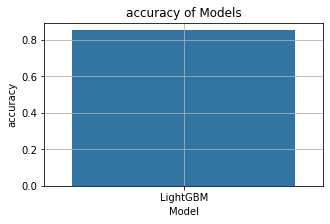

accuracy : {'LightGBM': 0.8507069517913791}
-----------


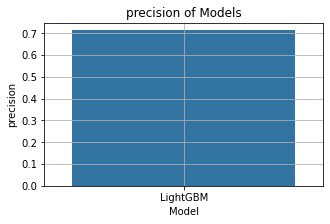

precision : {'LightGBM': 0.7116552135639432}
-----------


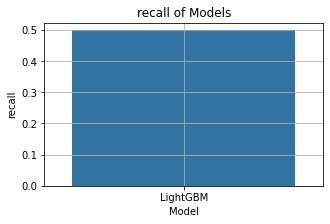

recall : {'LightGBM': 0.49826691729323314}
-----------


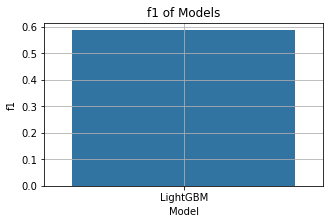

f1 : {'LightGBM': 0.58602846744261}
-----------


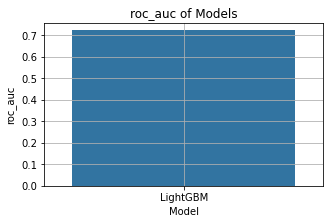

roc_auc : {'LightGBM': 0.7219547176658384}
-----------


In [57]:
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

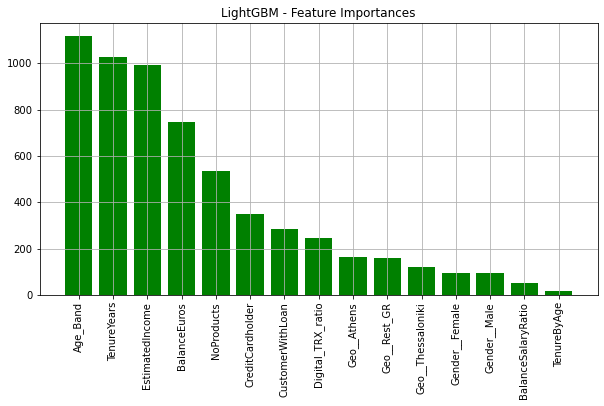

In [58]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.grid()
    plt.show()

### Extra Features experimentation

In [14]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 17) (10000,)


In [15]:
features_label

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods', 'older_with_loan',
       'older_with_no_credit_card', 'Geo__Athens', 'Geo__Rest_GR',
       'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male'],
      dtype='object')

In [16]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

>XGB 0.847 (0.002)
>XGB 0.847 (0.002)
>XGB 0.680 (0.007)
>XGB 0.475 (0.019)
>XGB 0.559 (0.012)
>XGB 0.709 (0.008)
>CART 0.783 (0.006)
>CART 0.783 (0.006)
>CART 0.470 (0.014)
>CART 0.489 (0.024)
>CART 0.479 (0.016)
>CART 0.674 (0.011)
>RF 0.850 (0.002)
>RF 0.850 (0.002)
>RF 0.710 (0.013)
>RF 0.447 (0.022)
>RF 0.548 (0.014)
>RF 0.700 (0.009)
>GB 0.858 (0.006)
>GB 0.858 (0.006)
>GB 0.766 (0.030)
>GB 0.436 (0.016)
>GB 0.556 (0.016)
>GB 0.701 (0.008)
>LightGBM 0.855 (0.004)
>LightGBM 0.855 (0.004)
>LightGBM 0.724 (0.018)
>LightGBM 0.472 (0.016)
>LightGBM 0.571 (0.013)
>LightGBM 0.713 (0.007)


In [17]:
results

{'XGB': [0.8475, 0.846, 0.8505, 0.846, 0.846],
 'CART': [0.774, 0.7865, 0.782, 0.7925, 0.781],
 'RF': [0.8485, 0.85, 0.85, 0.8525, 0.8475],
 'GB': [0.85, 0.8645, 0.8625, 0.8525, 0.8585],
 'LightGBM': [0.8495, 0.8535, 0.861, 0.8565, 0.856]}

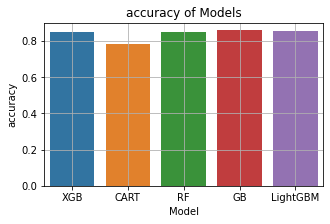

accuracy : {'XGB': 0.8472, 'CART': 0.7832000000000001, 'RF': 0.8497, 'GB': 0.8576, 'LightGBM': 0.8553000000000001}
-----------


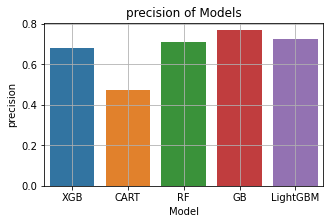

precision : {'XGB': 0.6804726359641614, 'CART': 0.4704611392805532, 'RF': 0.7101759672438248, 'GB': 0.7663871422694951, 'LightGBM': 0.7241013447080762}
-----------


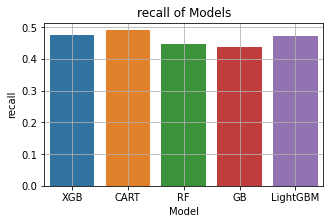

recall : {'XGB': 0.47502756603864044, 'CART': 0.4892180833213481, 'RF': 0.4471211467472075, 'GB': 0.43634642120907047, 'LightGBM': 0.4716009875832974}
-----------


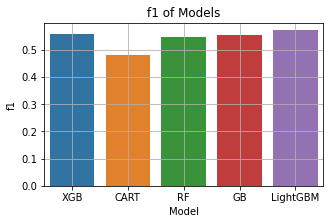

f1 : {'XGB': 0.5591860197263333, 'CART': 0.4794096320240331, 'RF': 0.5481899531741135, 'GB': 0.5558085459821003, 'LightGBM': 0.570892592573224}
-----------


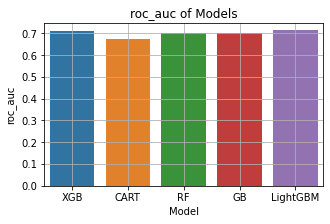

roc_auc : {'XGB': 0.7088633024581232, 'CART': 0.673925761968688, 'RF': 0.7000626232205759, 'GB': 0.7010206659832515, 'LightGBM': 0.7126794280607315}
-----------


In [18]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

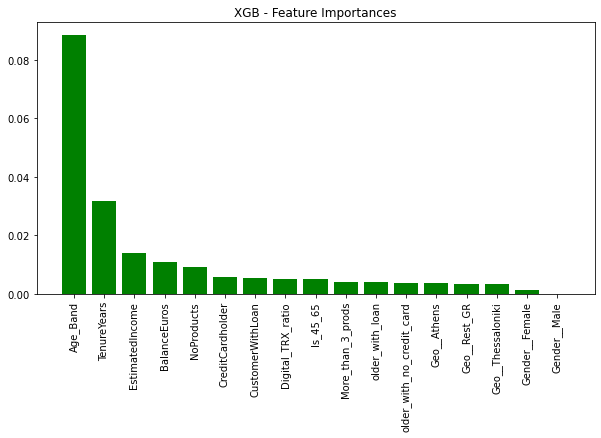

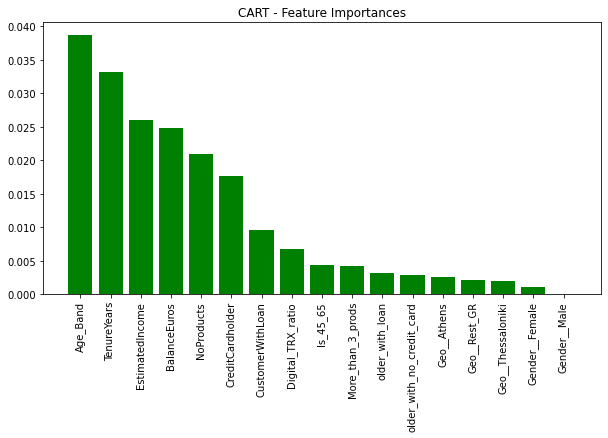

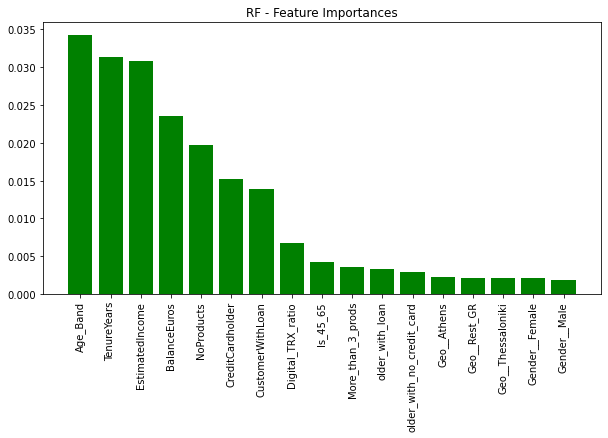

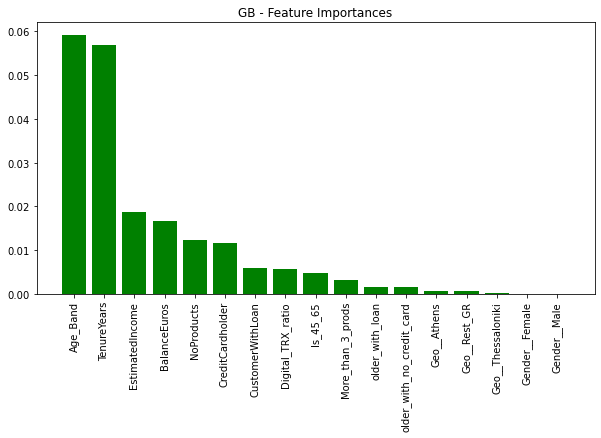

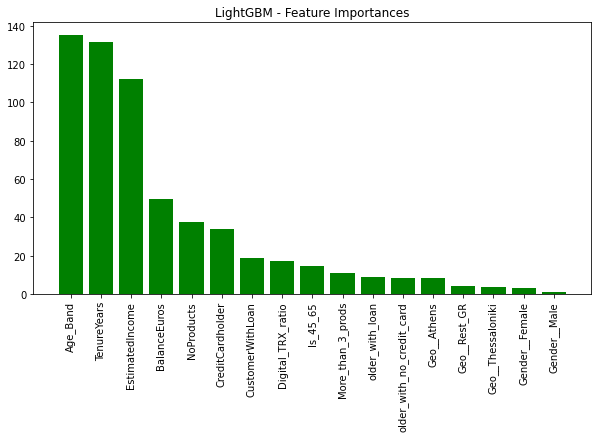

In [19]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [20]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.847 (0.002)
>CART 0.783 (0.006)
>RF 0.850 (0.002)
>GB 0.858 (0.006)
>LightGBM 0.855 (0.004)


In [37]:
results

{'LR': [0.5025, 0.4905, 0.4895, 0.503, 0.5025],
 'KNN': [0.5115, 0.537, 0.4895, 0.521, 0.516],
 'CART': [0.677, 0.6815, 0.7005, 0.6775, 0.7055],
 'RF': [0.768, 0.759, 0.769, 0.7645, 0.7825],
 'SVR': [0.217, 0.2175, 0.219, 0.2195, 0.2125],
 'GB': [0.781, 0.7825, 0.7805, 0.776, 0.7835],
 'LightGBM': [0.7545, 0.7755, 0.776, 0.7685, 0.7765]}

## Experiment with SMOTE - Teckle imblanace dataset

In [198]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 17) (10000,)


In [199]:
# import smote oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy - oversample minority class to have 20% of majority class and leave majority class as is
# oversample = SMOTE(sampling_strategy='not majority', random_state=123456)
undersampler = RandomUnderSampler(sampling_strategy=0.8)

# fit and apply the transform
X, y = undersampler.fit_resample(X, y)

print(X.shape, y.shape)

(4594, 17) (4594,)


In [200]:
undersampler.sampling_strategy_

OrderedDict([(0, 2552)])

Class=0, n=2552 (55.551%)
Class=1, n=2042 (44.449%)


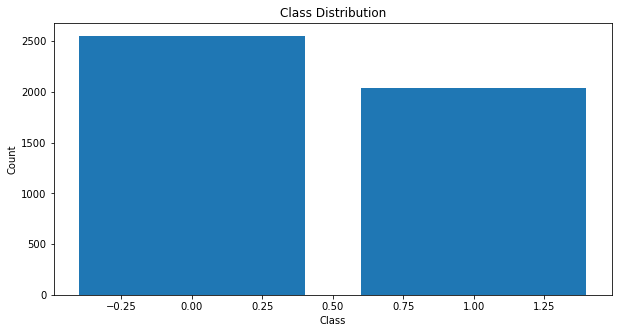

In [201]:
from collections import Counter
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
plt.figure(figsize=(10, 5))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.bar(counter.keys(), counter.values())
plt.show()


[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

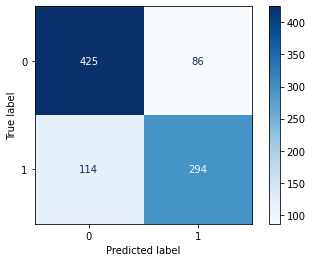

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


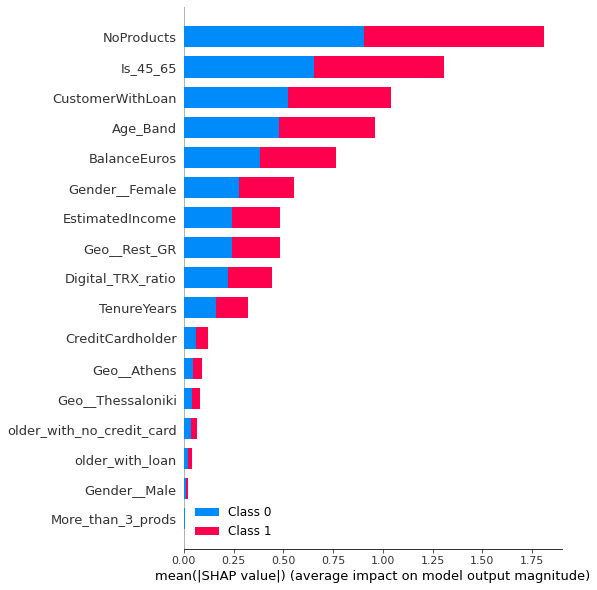

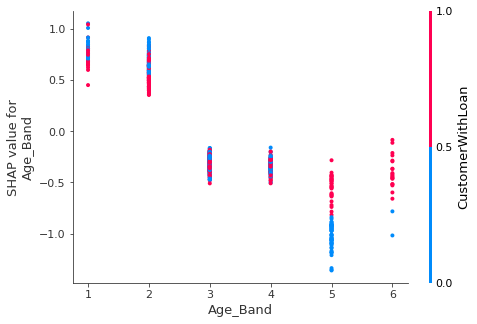

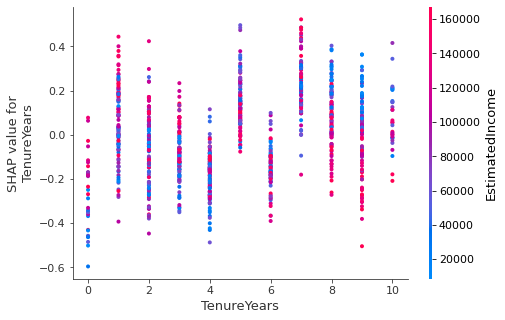

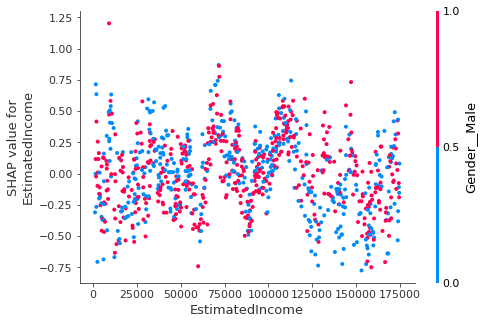

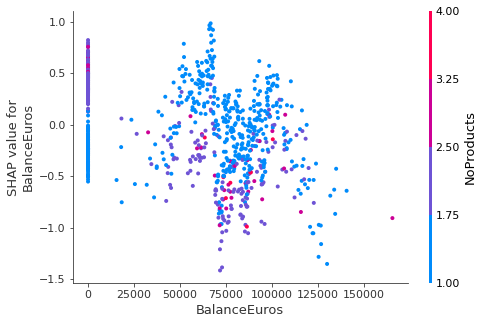

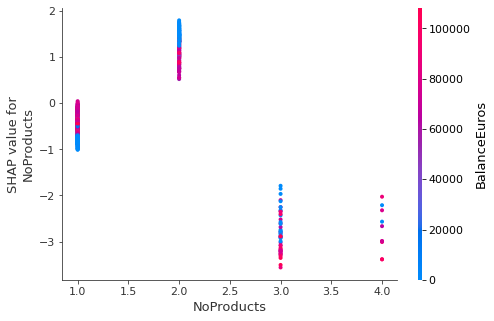

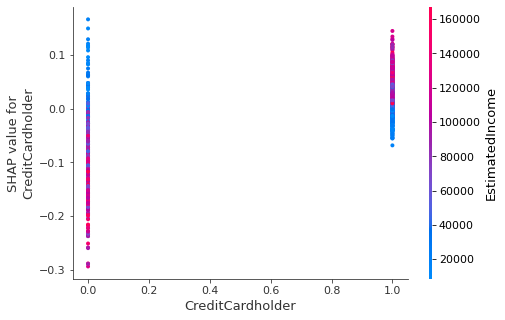

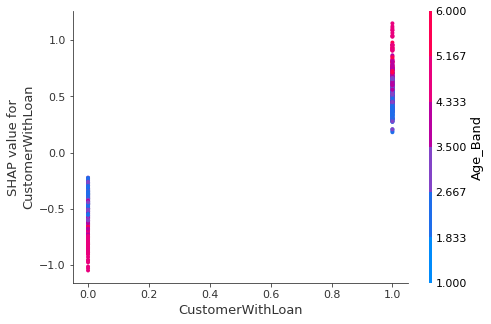

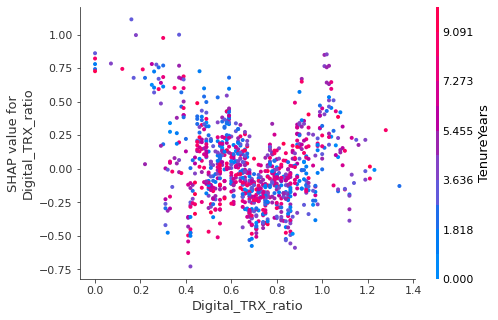

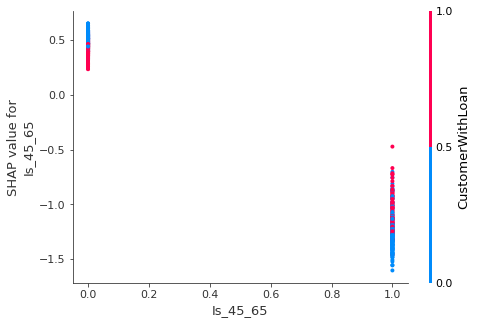

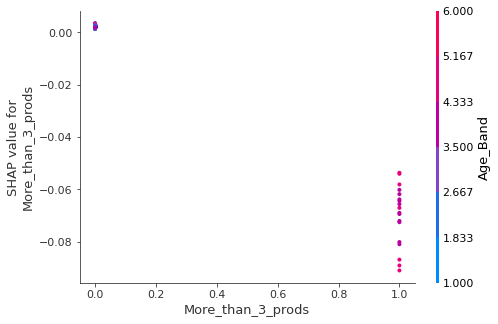

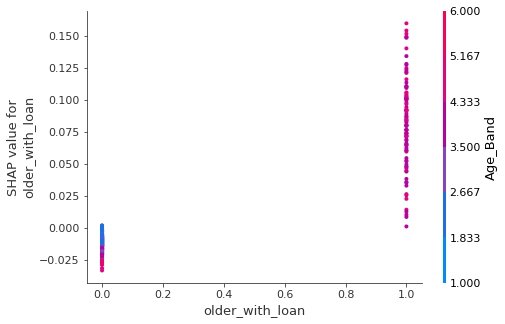

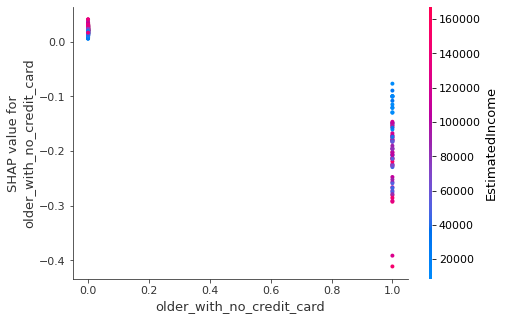

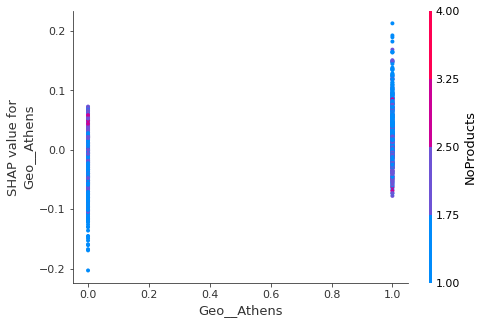

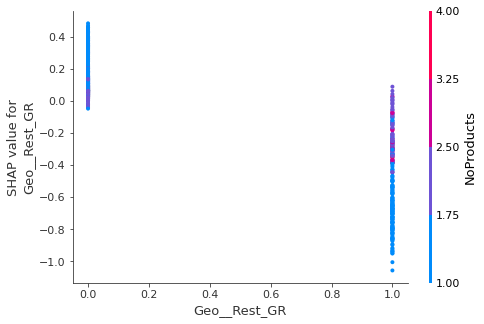

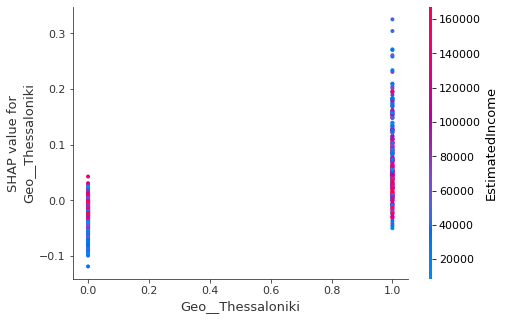

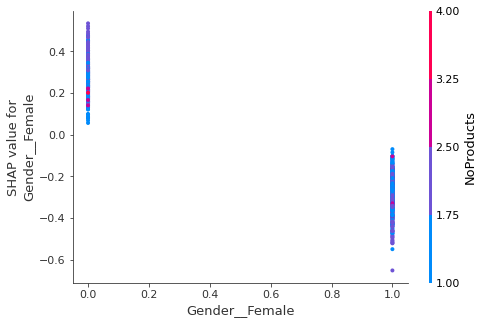

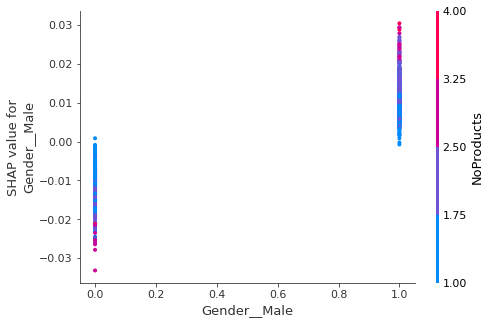

[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

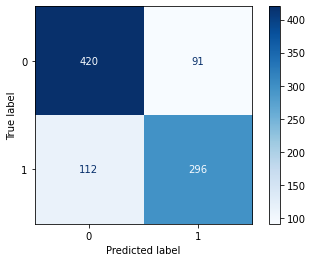

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


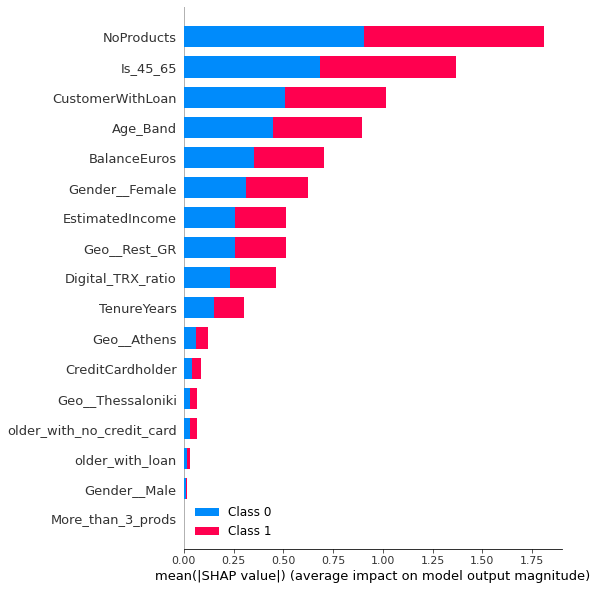

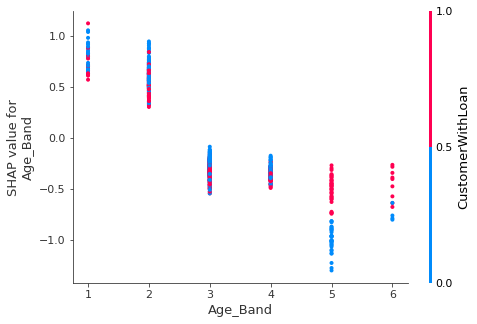

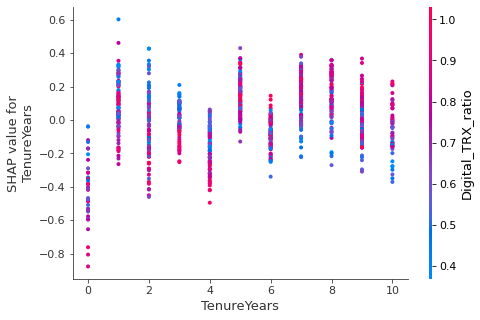

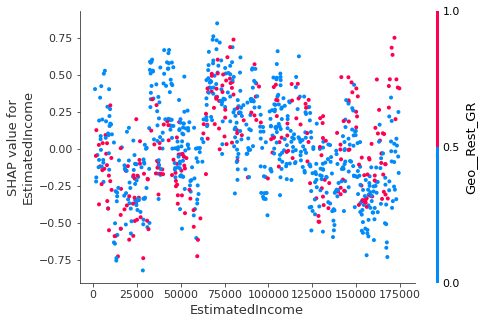

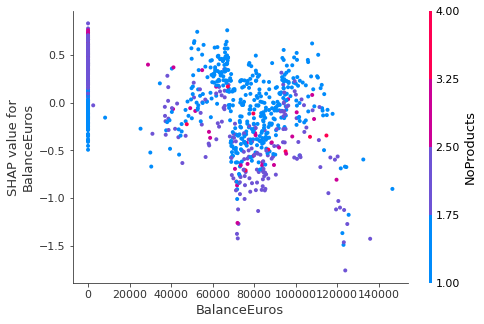

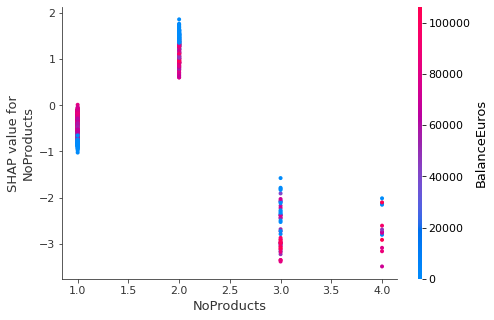

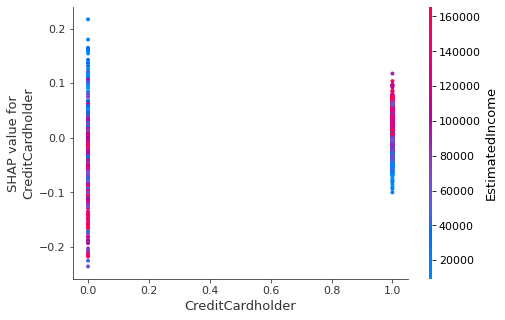

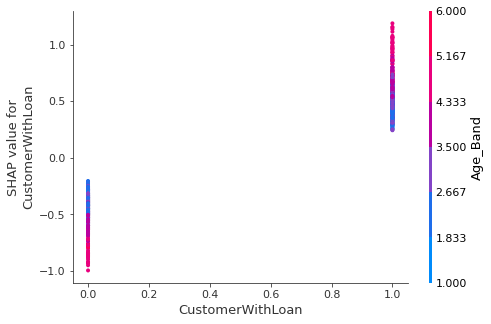

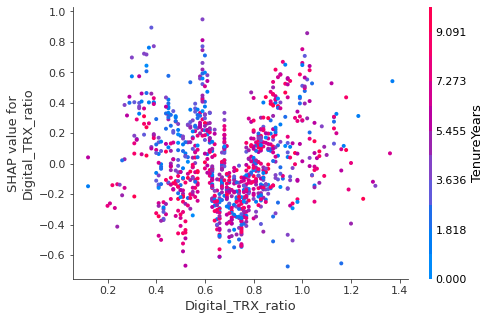

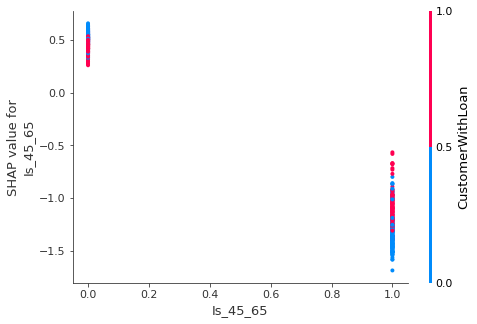

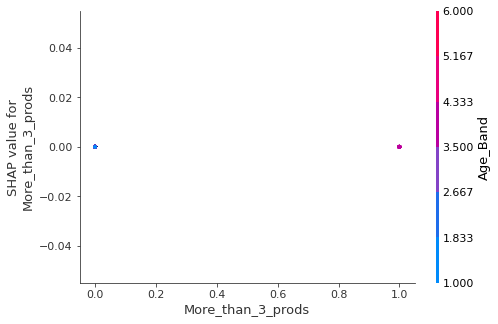

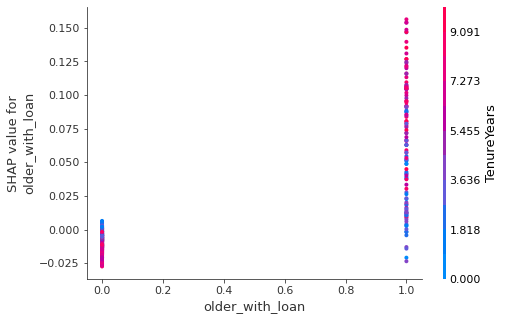

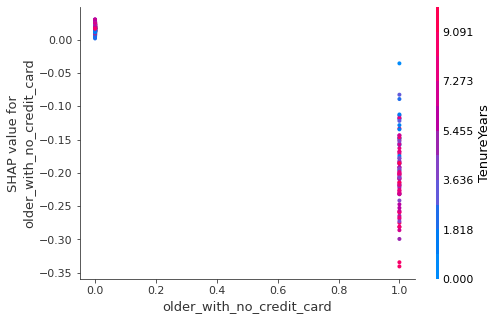

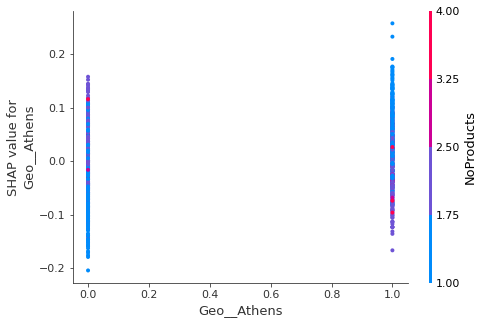

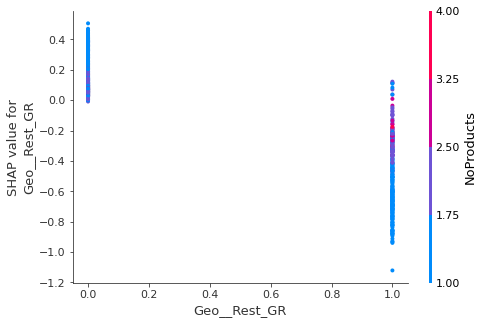

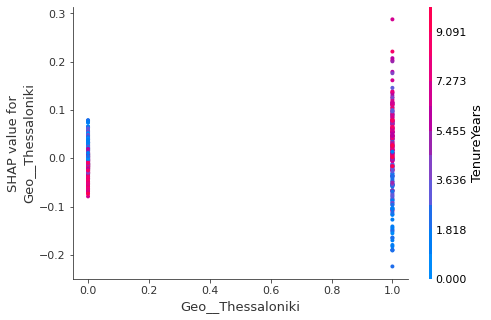

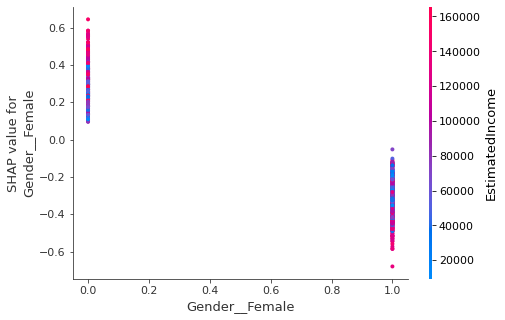

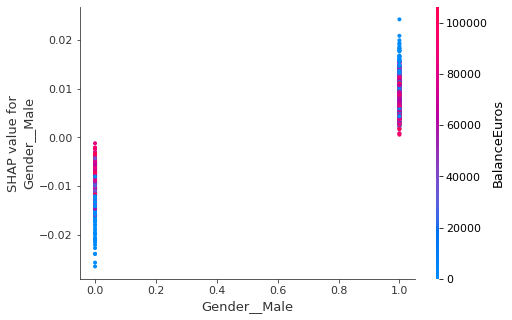

[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

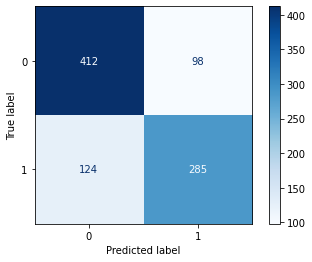

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


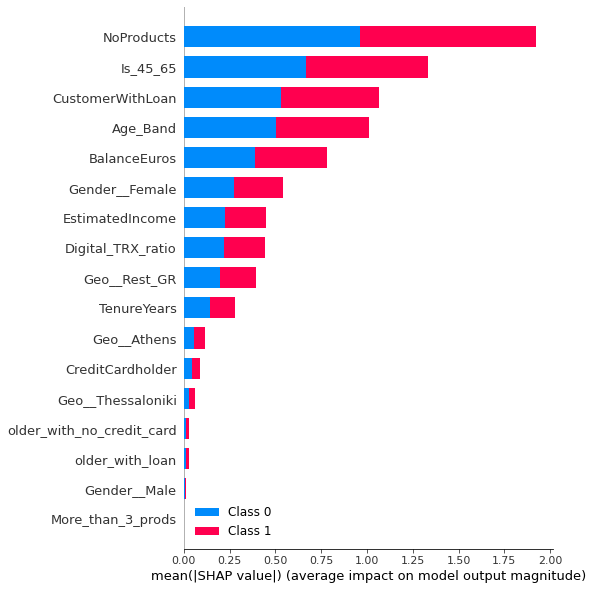

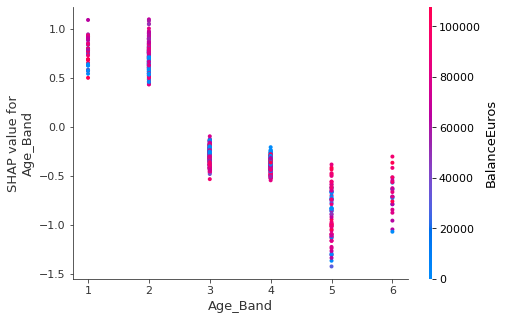

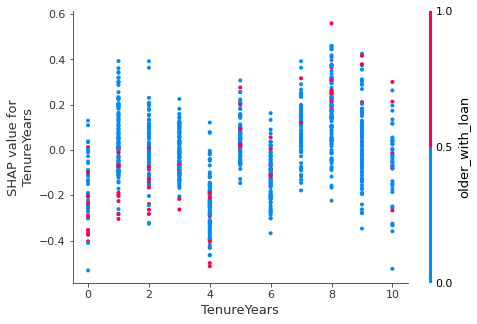

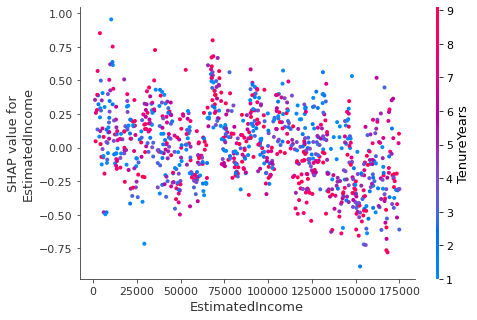

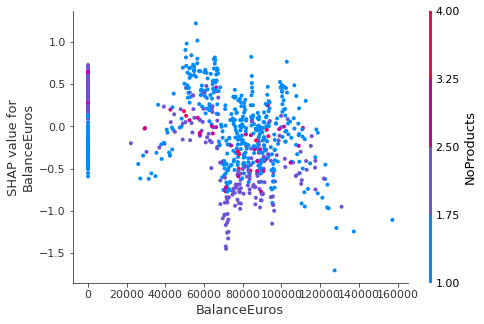

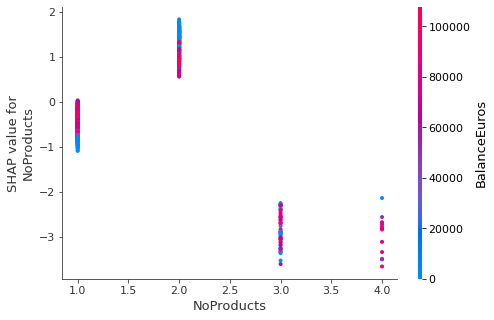

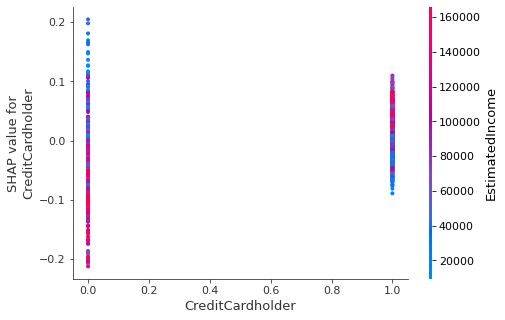

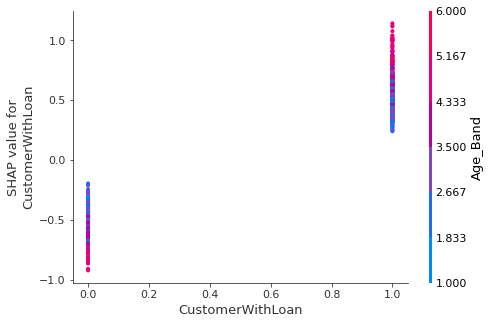

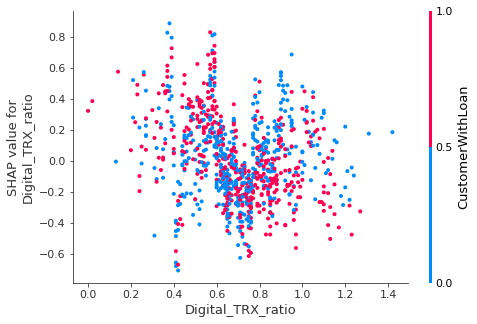

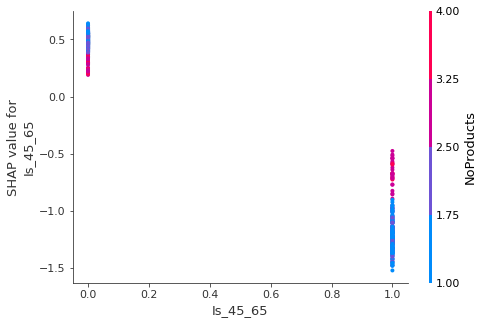

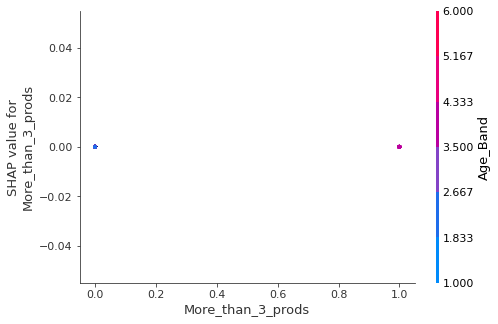

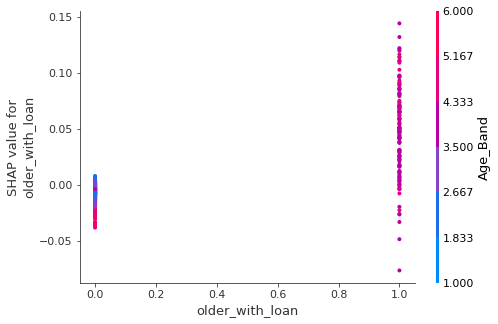

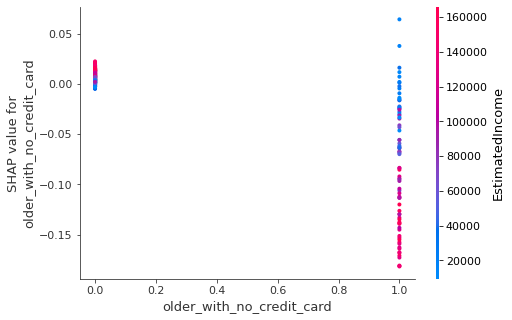

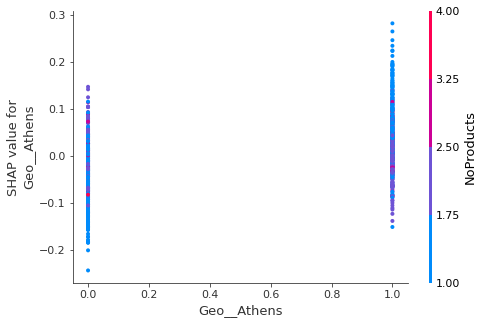

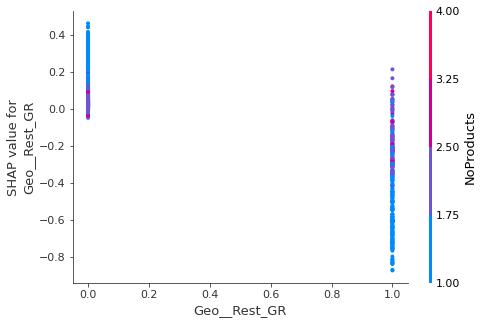

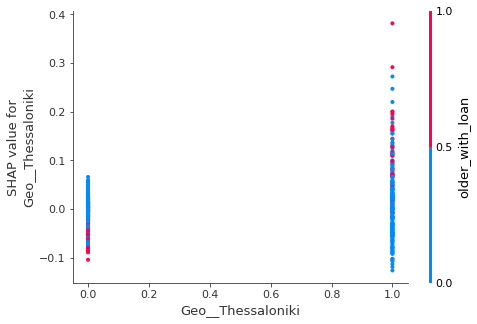

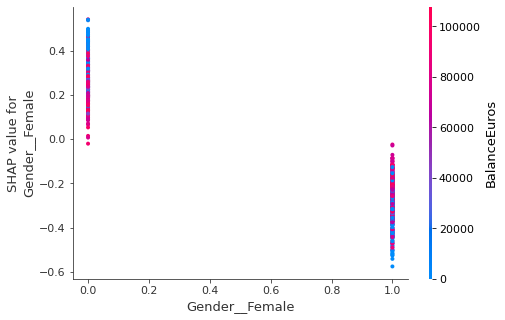

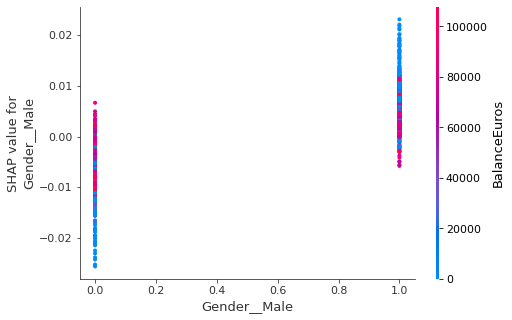

[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

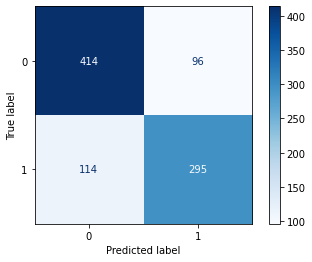

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


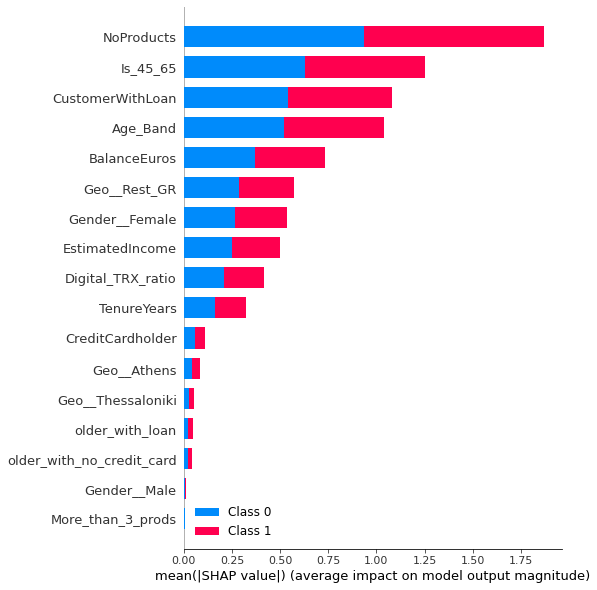

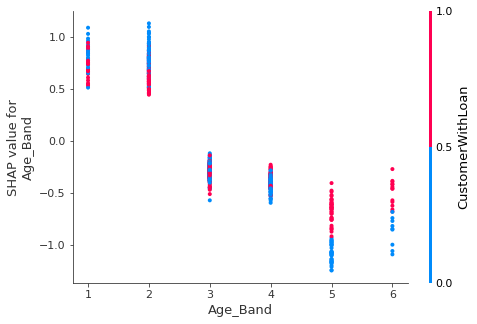

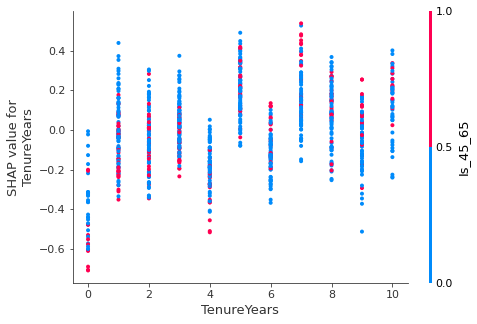

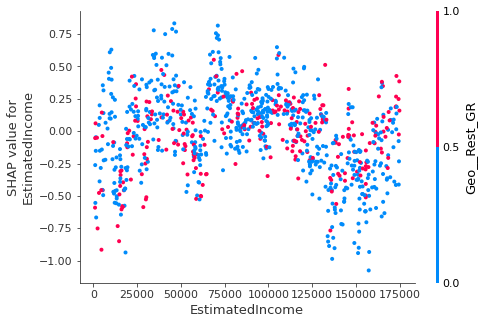

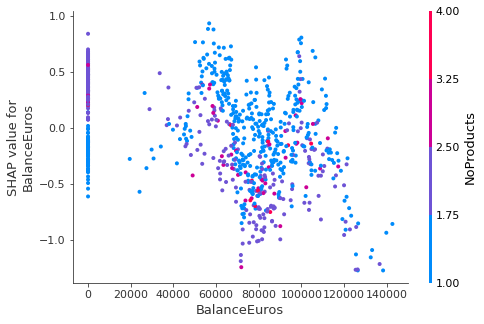

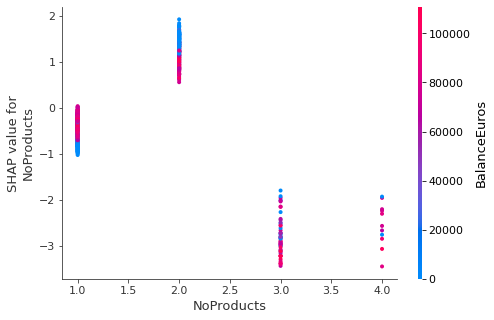

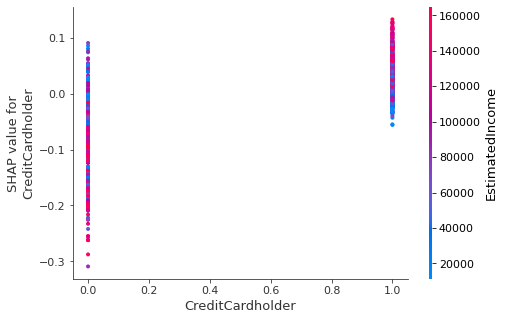

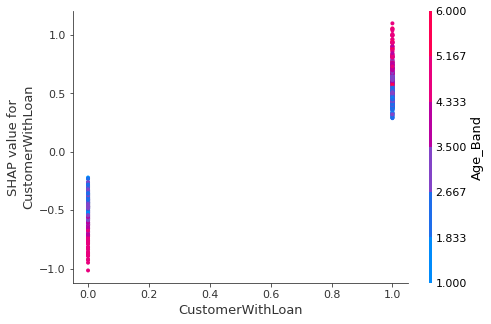

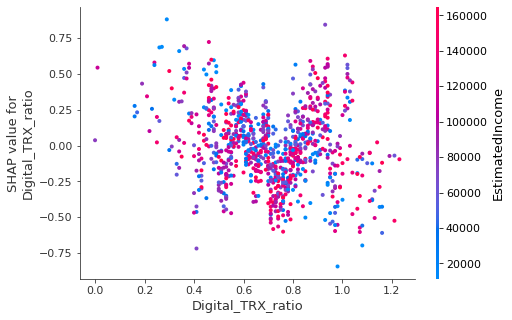

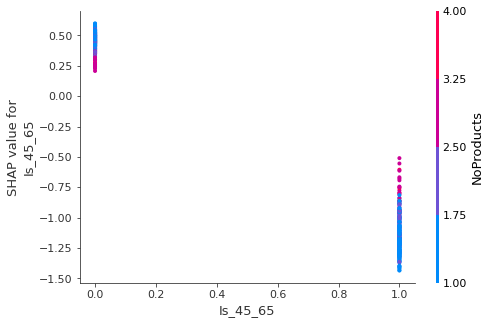

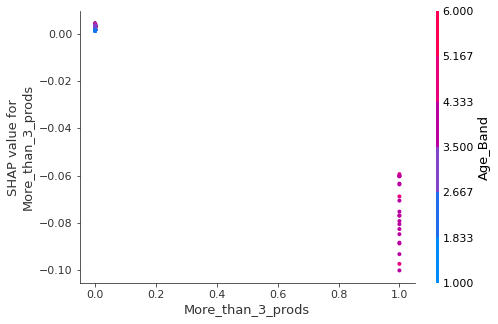

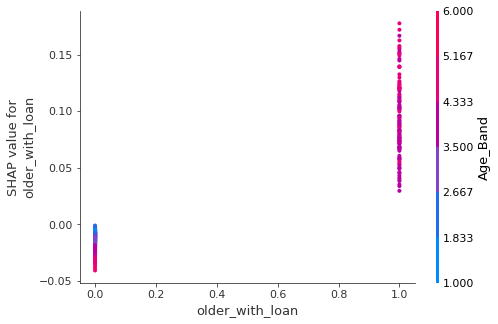

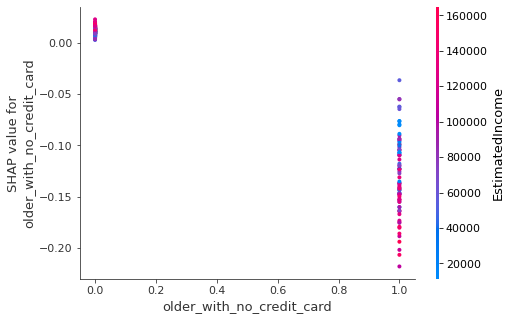

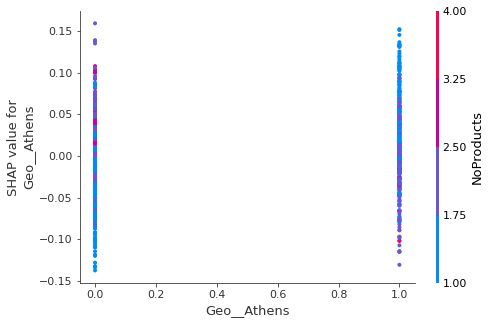

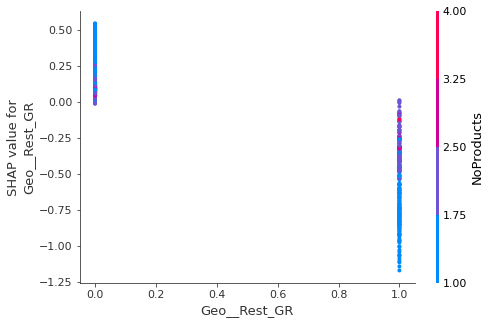

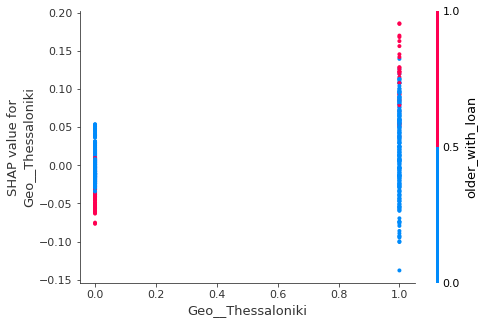

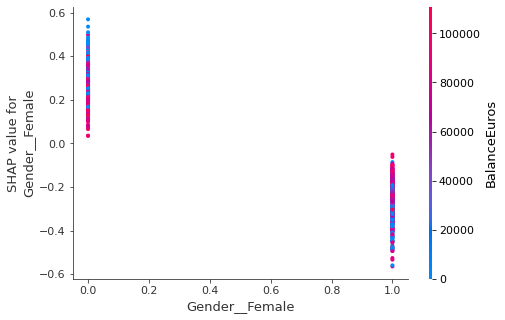

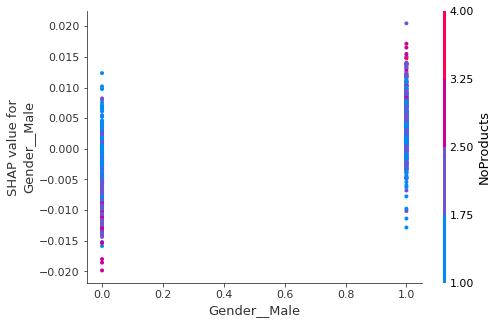

[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

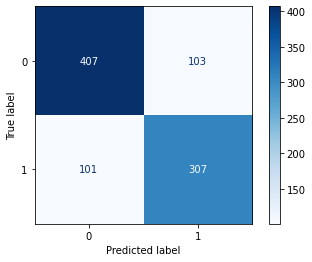

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


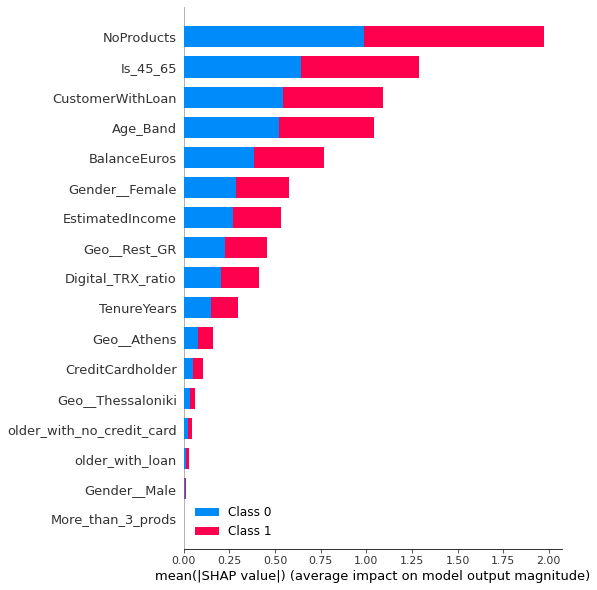

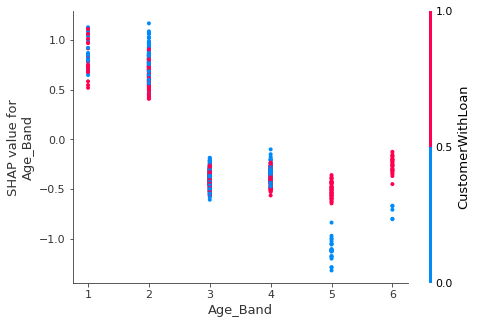

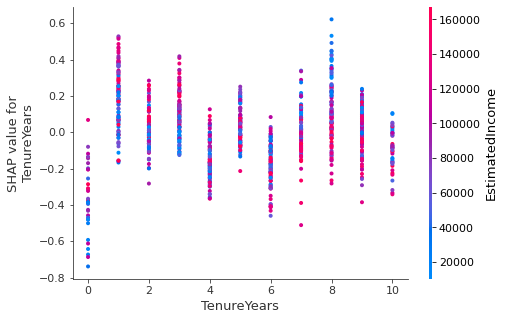

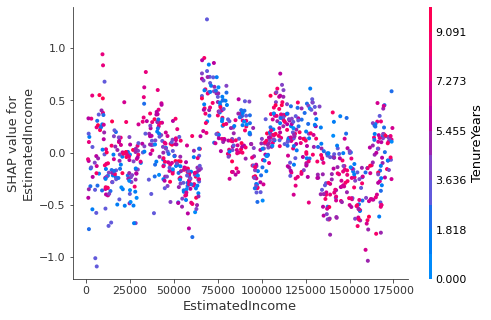

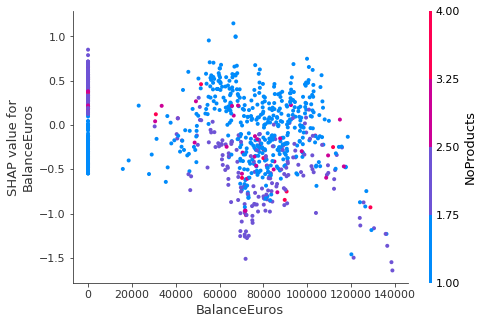

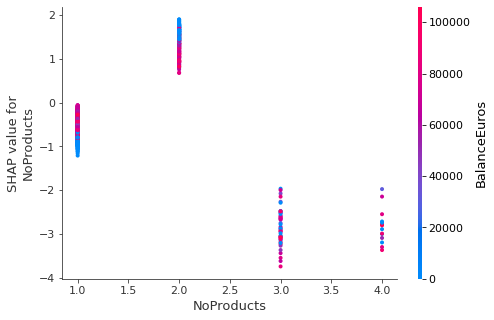

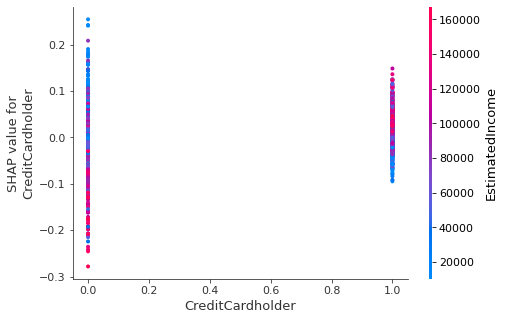

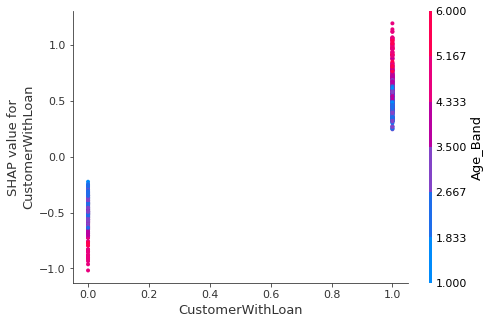

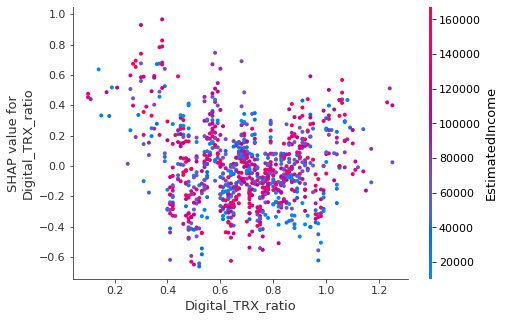

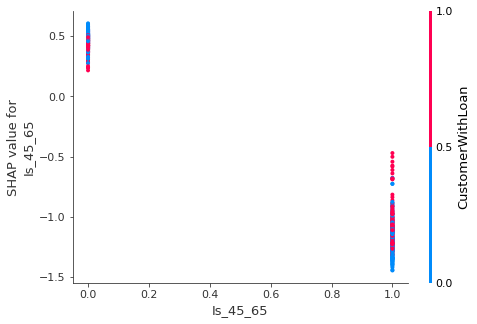

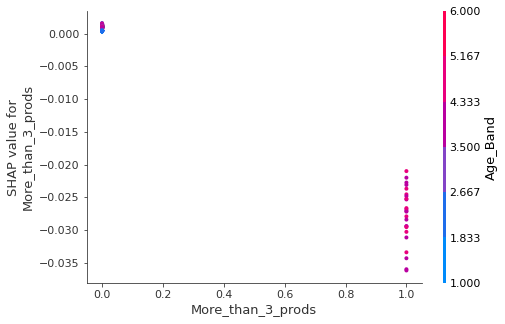

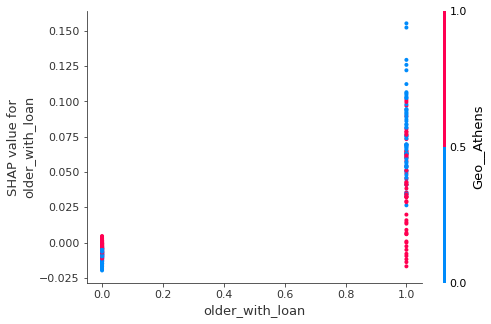

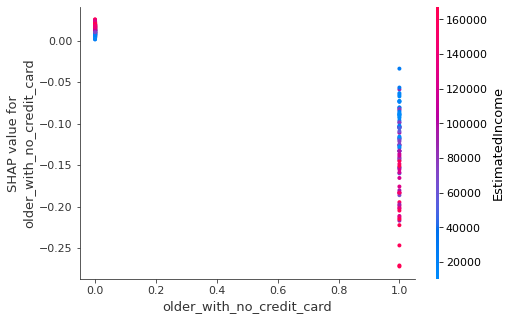

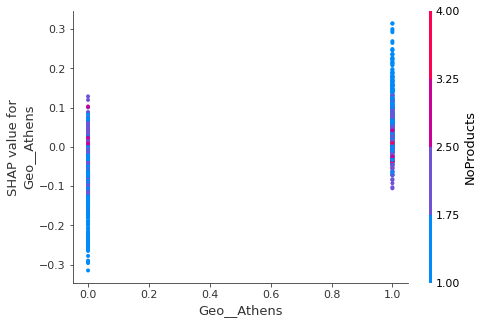

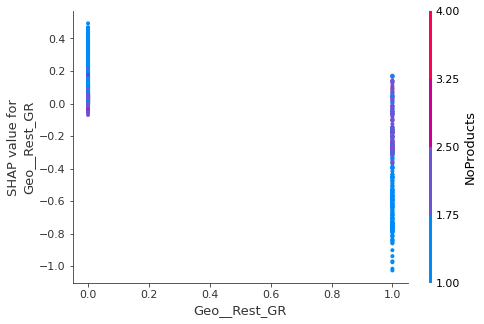

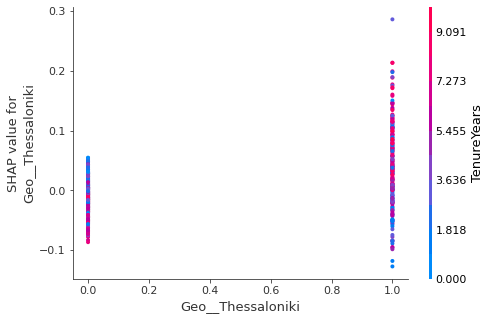

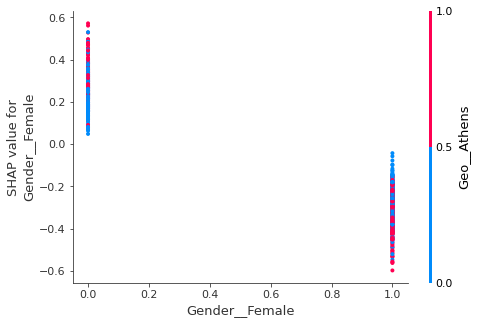

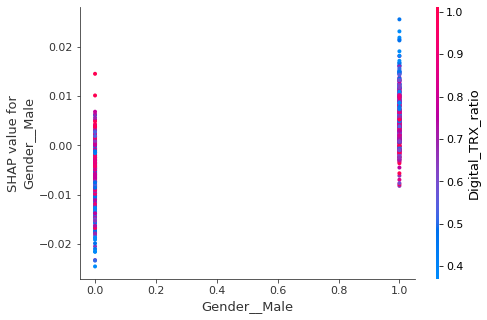

>LightGBM 0.774 (0.008)
>LightGBM 0.774 (0.008)
>LightGBM 0.757 (0.011)
>LightGBM 0.723 (0.018)
>LightGBM 0.740 (0.011)
>LightGBM 0.769 (0.009)


In [202]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
import sklearn

import shap

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': 0.014,
    'subsample': 0.9249682718298411,
    'subsample_freq': 0.7580854915970148,
    'colsample_bytree': 0.9768551421448343,
    'reg_alpha': 0.0029587956244222367,
    'reg_lambda': 0.21206304009356328,
    'min_child_weight': 5,
    'min_child_samples': 50,
    'bagging_fraction': 0.683304123698687,
    'bagging_freq': 1,
    'random_state':123456
}

to_print_shapes = False

# Models for Classification
models = [("LightGBM", LGBMClassifier(**lgbm_params))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

roc_curve_per_model = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    true_positive_rate_per_fold = []
    false_positive_rate_per_fold = []
    classification_report_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))
        
        fpr1, tpr1, _ = sklearn.metrics.roc_curve(test_y, y_pred)
        true_positive_rate_per_fold.append(tpr1)
        false_positive_rate_per_fold.append(fpr1)

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # plot classification matrix for each fold
        plt.figure()
        plot_confusion_matrix(model, test_X, test_y, cmap=plt.cm.Blues)
        plt.show()

        # explain the model's predictions using SHAP
        X_test = pd.DataFrame(test_X, columns=features_label)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)

        for name_ in X_test.columns:
            shap.dependence_plot(name_, shap_values[0], X_test)

        # # plot roc curve for each fold
        # plt.figure()
        # plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test_y, y_pred))
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title(f'ROC Curve - {name}')
        # plt.legend(loc="lower right")
        # plt.show()

        # # append classification report for each fold
        # print(classification_report(test_y, y_pred))
        # classification_report_per_fold.append(classification_report(test_y,  y_pred))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)
    # mean value of true_positive_rate_per_fold and false_positive_rate_per_fold
    true_positive_rate_per_fold = np.mean(true_positive_rate_per_fold, axis=0)
    false_positive_rate_per_fold = np.mean(false_positive_rate_per_fold, axis=0)
    #
    roc_curve_per_model[name] = [true_positive_rate_per_fold, false_positive_rate_per_fold]

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

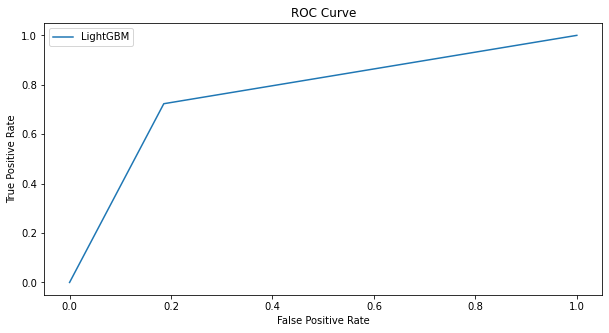

In [203]:
# roc curve for each model in the same plot
plt.figure(figsize=(10, 5))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for name, model in models:
    plt.plot(roc_curve_per_model[name][1], roc_curve_per_model[name][0], label=name)
plt.legend()

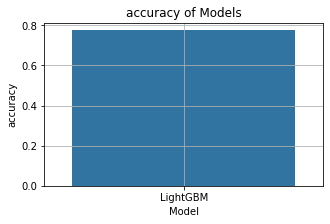

accuracy : {'LightGBM': 0.7738362954902671}
-----------


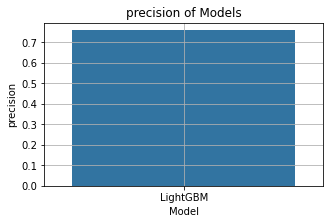

precision : {'LightGBM': 0.757184721832742}
-----------


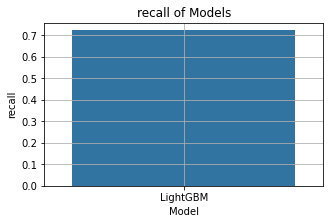

recall : {'LightGBM': 0.7233244642600316}
-----------


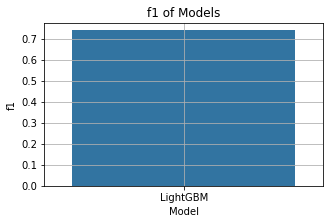

f1 : {'LightGBM': 0.7397310396184128}
-----------


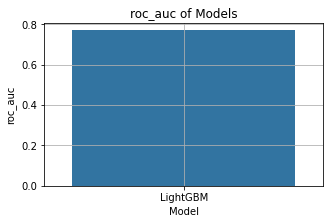

roc_auc : {'LightGBM': 0.7687889732374178}
-----------


In [206]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

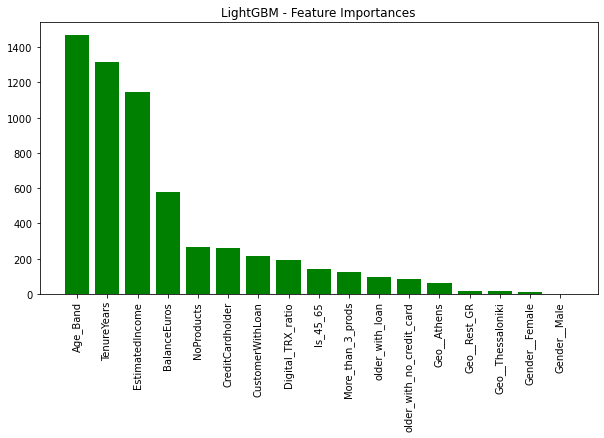

In [207]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [208]:
roc_auc

{'LightGBM': 0.7687889732374178}

In [209]:
f1

{'LightGBM': 0.7397310396184128}